In [144]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import silhouette_score
from matplotlib.patches import Ellipse
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [145]:
# Load CSVs and annotate metadata
v = pd.read_csv("../../01_concreteness/01_verbs/data/processed.csv")
v["Category"] = "Verbs"
v["Experiment"] = "Ex1: Conc-Abs"

n = pd.read_csv("../../01_concreteness/02_nouns/data/processed.csv")
n["Category"] = "Nouns"
n["Experiment"] = "Ex1: Conc-Abs"

a = pd.read_csv("../../01_concreteness/03_adjectives/data/processed.csv")
a["Category"] = "Adjs"
a["Experiment"] = "Ex1: Conc-Abs"

# a2 = pd.read_csv("../../06_soc-phys/00_pilot/data/processed.csv")
# a2["Category"] = "Adjs"
# a2["Experiment"] = "Ex2b: Phys-Soc"

# v2 = pd.read_csv("../../02_phys-psych/01_experiment/data/processed.csv")
# v2["Category"] = "Verbs"
# v2["Experiment"] = "Ex2a: Phys-Psych"

# n2 = pd.read_csv("../../04_animacy/data/processed.csv")
# n2["Category"] = "Nouns"
# n2["Experiment"] = "Ex3: Animacy"

# s = pd.read_csv("../../05_syntactic/01_experiment/data/processed.csv")
# s["Experiment"] = "Ex4: Syntactic"

# Combine all dataframes
d = pd.concat([v, n, a], ignore_index=True)
d = d[["ID.true","Word","Accuracy","ReactionTime","Task","ConcValCombo","Category"]]
d[['Concreteness', 'Valence']] = d['ConcValCombo'].str.split('-', expand=True)

In [17]:
print(len(d))
d.columns

29040


Index(['ID.true', 'Word', 'Accuracy', 'ReactionTime', 'Task', 'ConcValCombo',
       'Category', 'Concreteness', 'Valence'],
      dtype='object')

In [116]:
# Step 1: Filter to relevant tasks
filtered = d[d["Task"].isin(["Valence", "Concrete"])]

# Step 2: Grab unique word-level features like concreteness/valence (assuming they don't vary per participant)
word_features = filtered[['Word', 'Concreteness', 'Valence','Category']].drop_duplicates()

# Step 3: Group by Word and Task, then compute mean ReactionTime and Accuracy
agg = (
    filtered.groupby(["Word", "Task"], as_index=False)
    .agg({
        "ReactionTime": "mean",
        "Accuracy": "mean"
    })
)

# Step 4: Pivot to wide format
wide = agg.pivot(index="Word", columns="Task")
wide.columns = [f"Mean_{metric}_{task}" for metric, task in wide.columns]
wide = wide.reset_index()

# Step 5: Merge back the concreteness/valence columns
wide = wide.merge(word_features, on="Word", how="left")


In [117]:
print(len(wide))
wide.head()

120


,Word,Mean_ReactionTime_Concrete,Mean_ReactionTime_Valence,Mean_Accuracy_Concrete,Mean_Accuracy_Valence,Concreteness,Valence,Category
0,admired,1156.566667,867.758333,0.941667,0.991667,abstract,positive,Verbs
1,annoy,1096.400000,823.158333,0.858333,0.966667,abstract,negative,Verbs
2,anxiety,916.349593,906.552846,0.894309,0.918699,abstract,negative,Nouns
3,awful,930.866667,792.383333,0.933333,0.975000,abstract,negative,Adjs
4,beach,1023.195122,738.040650,0.975610,0.983740,concrete,positive,Nouns


1. Hierarchical Clustering
- Good for smaller word sets.

- Produces a dendrogram showing relationships between words.

- Distance metric: Euclidean (or Mahalanobis if you want to account for variable correlations).

- Can cut the tree to get desired number of clusters.


2. K-Means Clustering
- Requires specifying the number of clusters.

- Works well if your data are mostly globular in structure (e.g., words cluster around centroids).

- Use elbow method or silhouette score to determine optimal number of clusters.


3. Gaussian Mixture Models (GMM)
- Probabilistic model; more flexible than k-means.

- Good if clusters may overlap or are not strictly spherical.

- Can give soft clustering (a word can belong to multiple clusters with probabilities).


4. DBSCAN or HDBSCAN
- Density-based clustering; good if you suspect non-globular or unevenly distributed clusters.

- Doesn't require a preset number of clusters.

- HDBSCAN handles varying densities better and is more robust.


# Cluster Analysis using k-means

## Without valence and Concreteness

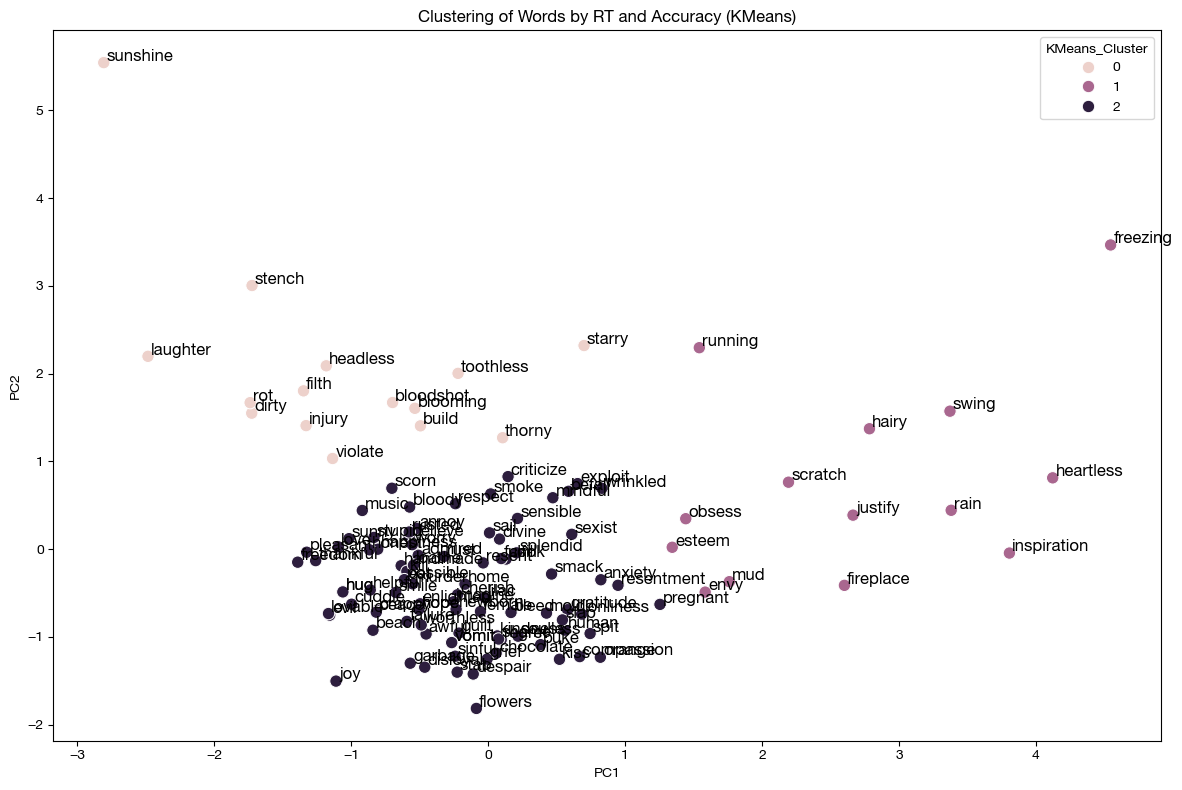

In [136]:


# Assume df is your dataframe with each row as a word
features = ['Mean_ReactionTime_Valence', 'Mean_Accuracy_Valence', 'Mean_ReactionTime_Concrete', 'Mean_Accuracy_Concrete']
X = StandardScaler().fit_transform(wide[features])

# Run KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
wide['KMeans_Cluster'] = kmeans.fit_predict(X)

# PCA for visualization
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(X)
wide['PC1'], wide['PC2'] = pca_coords[:, 0], pca_coords[:, 1]

# Plot
# sns.scatterplot(data=wide, x='PC1', y='PC2', hue='Cluster')
# plt.title("Clustering of Words by RT and Accuracy")
# plt.show()

# Plot the PCA scatter with clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=wide, x='PC1', y='PC2', hue='KMeans_Cluster', s=80)

# Add word labels
for i, row in wide.iterrows():
    plt.text(row['PC1'] + 0.02, row['PC2'] + 0.02, str(row['Word']), fontsize=16)

plt.title("Clustering of Words by RT and Accuracy (KMeans)")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='KMeans_Cluster')
plt.tight_layout()
plt.show()


In [81]:
wide.head()

,Word,Mean_ReactionTime_Concrete,Mean_ReactionTime_Valence,Mean_Accuracy_Concrete,Mean_Accuracy_Valence,Concreteness,Valence,Category,Cluster,PC1,PC2,GMM_Cluster,KMeans_Cluster
0,admired,1156.566667,867.758333,0.941667,0.991667,abstract,positive,Verbs,2,-0.510783,-0.069519,2,2
1,annoy,1096.400000,823.158333,0.858333,0.966667,abstract,negative,Verbs,2,-0.520805,0.235237,2,2
2,anxiety,916.349593,906.552846,0.894309,0.918699,abstract,negative,Nouns,2,0.822811,-0.348483,2,2
3,awful,930.866667,792.383333,0.933333,0.975000,abstract,negative,Adjs,2,-0.453259,-0.966973,2,2
4,beach,1023.195122,738.040650,0.975610,0.983740,concrete,positive,Nouns,2,-0.841273,-0.923615,2,2


In [137]:
# Group by cluster and print words in each
# for cluster_id, group in wide.groupby('KMeans_Cluster'):
#     print(f"\nCluster {cluster_id} ({len(group)} words):")
#     print(", ".join(group['Word'].astype(str)))


# Group by cluster and print Valence, Concreteness, and grouped Words
for cluster_id, cluster_group in wide.groupby('KMeans_Cluster'):
    print(f"\nCluster {cluster_id} ({len(cluster_group)} words):")
    
    grouped = cluster_group.groupby(['Valence', 'Concreteness'])
    for (valence, concreteness), group in grouped:
        words = ", ".join(sorted(group['Word'].astype(str)))
        print(f"Valence: {valence}, Concreteness: {concreteness} \n {words}")



Cluster 0 (15 words):
Valence: negative, Concreteness: abstract 
 violate
Valence: negative, Concreteness: concrete 
 bloodshot, dirty, filth, headless, injury, rot, stench, thorny, toothless
Valence: positive, Concreteness: concrete 
 blooming, build, laughter, starry, sunshine

Cluster 1 (14 words):
Valence: negative, Concreteness: abstract 
 envy, heartless, obsess
Valence: negative, Concreteness: concrete 
 freezing, hairy, mud, scratch
Valence: positive, Concreteness: abstract 
 esteem, inspiration, justify
Valence: positive, Concreteness: concrete 
 fireplace, rain, running, swing

Cluster 2 (91 words):
Valence: negative, Concreteness: abstract 
 annoy, anxiety, awful, befall, crappy, criticize, despair, disloyal, evil, exploit, failure, grief, guilt, loathe, lonliness, regret, resent, resentment, scorn, sexist, shame, sinful, soulless, stupid, worry, worthless
Valence: negative, Concreteness: concrete 
 bleed, bloody, garbage, kill, mold, murder, puke, rust, rusted, slap, smack

## Evaluate

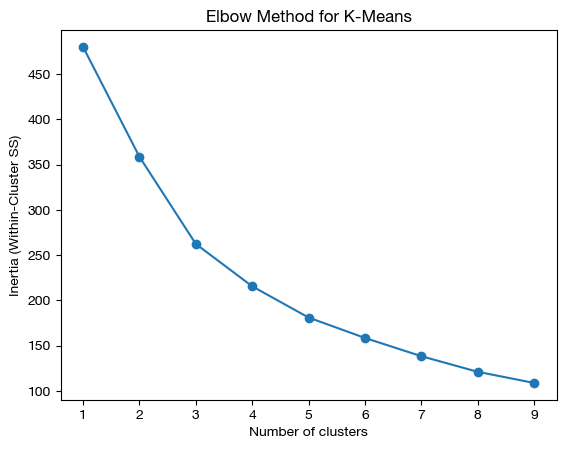

In [76]:
inertias = []
k_values = range(1, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (Within-Cluster SS)')
plt.title('Elbow Method for K-Means')
plt.show()


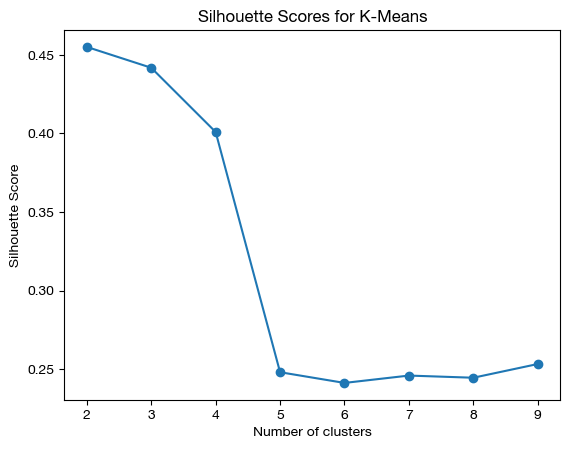

In [77]:
sil_scores = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

plt.plot(range(2, 10), sil_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for K-Means')
plt.show()


# Cluster analysis using Gaussian Mixture Model

In [167]:

# Select only the features for clustering
features = ['Mean_ReactionTime_Valence', 'Mean_Accuracy_Valence', 'Mean_ReactionTime_Concrete', 'Mean_Accuracy_Concrete']
X = wide[features]

# Standardize the data (important for GMM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Try different numbers of clusters (e.g., 2 to 6)
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X_scaled)

# Predict cluster membership (hard labels)
wide['GMM_Cluster'] = gmm.predict(X_scaled)

# Optional: Probabilities of each word belonging to each cluster
probs = gmm.predict_proba(X_scaled)

In [168]:

# Group by cluster and print as a table with categorical Valence and Concreteness
for cluster_id, cluster_group in wide.groupby('GMM_Cluster'):
    print(f"\nCluster {cluster_id} ({len(cluster_group)} words):")
    print(f"{'Valence / Concreteness':<30} | Words")
    print("-" * 70)

    grouped = cluster_group.groupby(['Valence', 'Concreteness'])
    for (valence, concreteness), group in grouped:
        val_conc = f"{valence} / {concreteness}"
        words = ", ".join(sorted(group['Word'].astype(str)))
        print(f"{val_conc:<30} | {words}")



Cluster 0 (18 words):
Valence / Concreteness         | Words
----------------------------------------------------------------------
negative / concrete            | bloodshot, bloody, dirty, filth, headless, injury, rot, rusted, stench, thorny, toothless, wrinkled
positive / concrete            | blooming, build, laughter, music, starry, sunshine

Cluster 1 (11 words):
Valence / Concreteness         | Words
----------------------------------------------------------------------
negative / abstract            | heartless
negative / concrete            | freezing, hairy, mud, scratch
positive / abstract            | inspiration, justify
positive / concrete            | fireplace, rain, running, swing

Cluster 2 (91 words):
Valence / Concreteness         | Words
----------------------------------------------------------------------
negative / abstract            | annoy, anxiety, awful, befall, crappy, criticize, despair, disloyal, envy, evil, exploit, failure, grief, guilt, loathe, lonli

## Visualization using PCA

If clusters appear well-separated and compact in 2D, the model is likely capturing meaningful structure.

Overlapping clusters suggest ambiguity or that clusters are not well-defined in the chosen feature space.

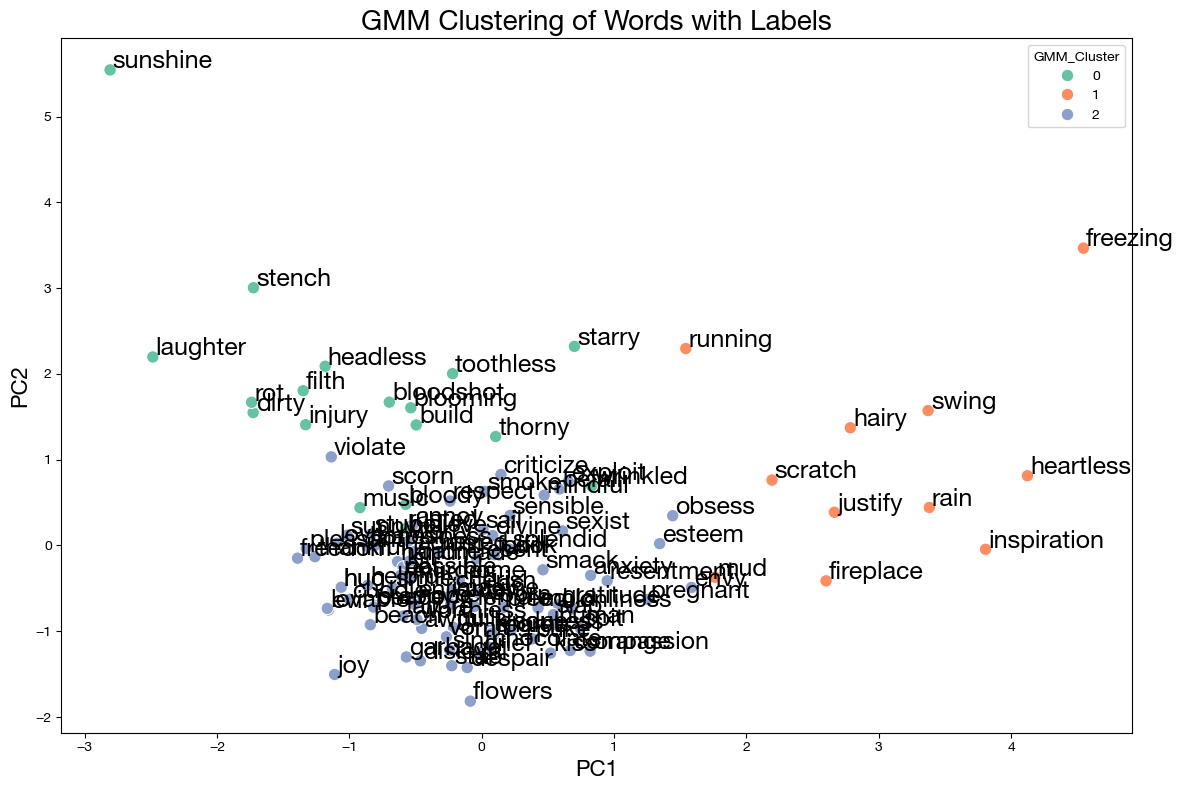

In [172]:
# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add to dataframe
wide['PC1'] = X_pca[:, 0]
wide['PC2'] = X_pca[:, 1]


# Basic scatterplot
sns.color_palette("rocket_r", as_cmap=True)
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(data=wide, x='PC1', y='PC2', palette="Set2", hue='GMM_Cluster', s=80)
# Set font to Helvetica Neue
plt.rcParams['font.family'] = 'Helvetica Neue'


# Add word labels
for i, row in wide.iterrows():
    plt.text(row['PC1'] + 0.02, row['PC2'] + 0.02, str(row['Word']), fontsize=18)

plt.title('GMM Clustering of Words with Labels', fontsize=20)
plt.xlabel('PC1', fontsize=16)
plt.ylabel('PC2', fontsize=16)
plt.legend(title='GMM_Cluster', loc='best')
plt.tight_layout()
# Save to PDF
plt.savefig("../graphs/gmm_clusters_plot.pdf", format='pdf')
plt.show()

## Evaluate model fit (AIC and BIC)

What they measure: Both are metrics that evaluate model quality by balancing model fit and complexity (number of parameters).

How to interpret:

Lower values indicate a better model.

When you plot AIC/BIC against the number of clusters, look for the "elbow" point or minimum value.

This helps you choose the optimal number of clusters without overfitting.

BIC tends to penalize complexity more harshly than AIC, so BIC often favors simpler models.

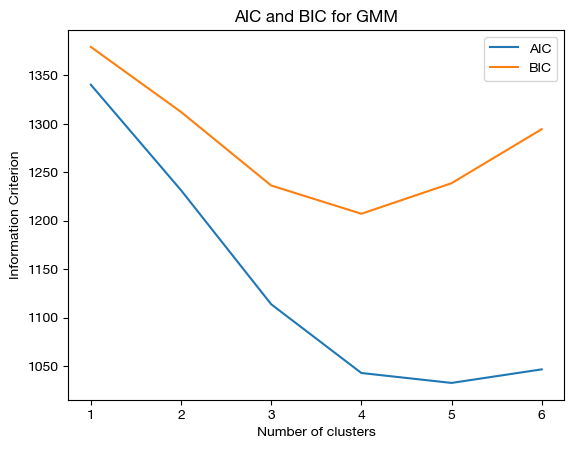

In [159]:
n_components = range(1, 7)
aic = []
bic = []

for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X_scaled)
    aic.append(gmm.aic(X_scaled))
    bic.append(gmm.bic(X_scaled))

plt.plot(n_components, aic, label='AIC')
plt.plot(n_components, bic, label='BIC')
plt.xlabel('Number of clusters')
plt.ylabel('Information Criterion')
plt.legend()
plt.title('AIC and BIC for GMM')
plt.show()


## Cluster Assignment uncertainty (Max Posterior Prob point-wise)

What it measures: For each data point, the highest probability assigned to any cluster (i.e., how confidently the model classifies the point).

How to interpret:

Values close to 1 mean the point clearly belongs to one cluster (low uncertainty).

Values closer to 0.5 or lower mean the model is uncertain, the point might lie between clusters or in overlapping regions.

A histogram skewed towards high probabilities indicates well-separated clusters.

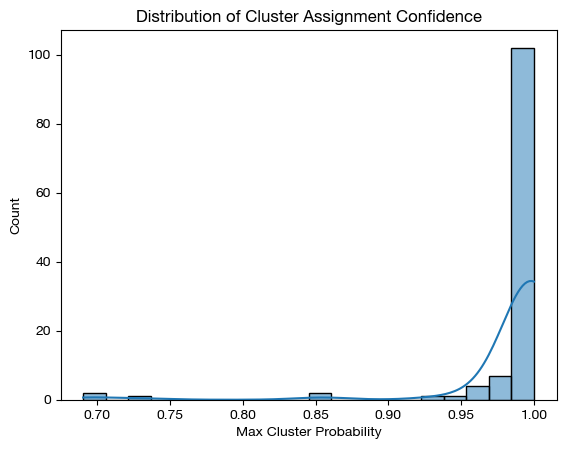

In [160]:
max_probs = probs.max(axis=1)

sns.histplot(max_probs, bins=20, kde=True)
plt.xlabel('Max Cluster Probability')
plt.title('Distribution of Cluster Assignment Confidence')
plt.show()


## Cluster size distribution

What it measures: Number of points assigned to each cluster.

How to interpret:

Balanced cluster sizes often indicate meaningful partitions.

Very small clusters might indicate outliers or noise, or an overly complex model.

Very large clusters with a few tiny ones might mean the model isn’t capturing finer structure or that some clusters are merging.

In [161]:
print(wide['GMM_Cluster'].value_counts())


GMM_Cluster
2    91
0    18
1    11
Name: count, dtype: int64


## Model Parameters

Means: The centroid of each Gaussian in feature space (after scaling).

Interpretation: Differences in means tell you how clusters differ along each feature.

Covariances: How spread out each cluster is and how features relate to each other within clusters.

Interpretation: Large covariance means a cluster is more spread; off-diagonal values indicate correlations between features in that cluster.

In [162]:
print("Means of each cluster (in scaled feature space):")
print(gmm.means_)

print("\nCovariances of each cluster:")
print(gmm.covariances_)


Means of each cluster (in scaled feature space):
[[ 0.34552462  0.43716471  0.32320791  0.44299297]
 [ 0.33014362 -1.88434266 -0.62443303  0.41064691]
 [-0.57466004  0.4222605  -0.37432387  0.35448109]
 [-1.34417535  0.52153994  7.39417413 -1.30335715]
 [ 2.79527638 -1.81598314  0.5001273   0.270872  ]
 [-0.30091894 -0.24352443 -0.03997118 -1.17670469]]

Covariances of each cluster:
[[[ 2.34930815e-01 -1.25032526e-01 -5.56782801e-02  3.58139028e-02]
  [-1.25032526e-01  2.13523630e-01  9.71036181e-03  1.14884342e-02]
  [-5.56782801e-02  9.71036181e-03  5.04286171e-01 -1.52968848e-01]
  [ 3.58139028e-02  1.14884342e-02 -1.52968848e-01  1.87879264e-01]]

 [[ 2.29947180e-02 -1.44589086e-01 -9.57102370e-03 -1.05123678e-02]
  [-1.44589086e-01  2.95238042e+00  1.60980882e-02  5.66310855e-01]
  [-9.57102370e-03  1.60980882e-02  3.02045903e-02 -3.60710736e-02]
  [-1.05123678e-02  5.66310855e-01 -3.60710736e-02  2.61733144e-01]]

 [[ 1.37853209e-01 -4.00920977e-02 -4.17564272e-02  1.91946434e-02

## Silhouette score

What it measures: How similar a point is to its own cluster compared to other clusters.

How to interpret:

Values range from -1 to 1.

Close to 1 = well-clustered; points are closer to their own cluster than to others.

Near 0 = points on the boundary between clusters.

Negative values = points may be assigned to the wrong cluster.

Though originally for hard clustering (like k-means), it can still give a rough idea of cluster separation for GMM clusters assigned by hard labels.

In [163]:

score = silhouette_score(X_scaled, wide['GMM_Cluster'])
print(f'Silhouette Score: {score:.3f}')


Silhouette Score: 0.430


## Visualize with Elipses

/var/folders/ng/p7mcfgw924986j7hgdgb5jg00000gn/T/ipykernel_43539/2406931951.py:14: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(position, width, height, angle, **kwargs)
/var/folders/ng/p7mcfgw924986j7hgdgb5jg00000gn/T/ipykernel_43539/2406931951.py:14: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(position, width, height, angle, **kwargs)
/var/folders/ng/p7mcfgw924986j7hgdgb5jg00000gn/T/ipykernel_43539/2406931951.py:14: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(position, width, height, angle, **kwargs)


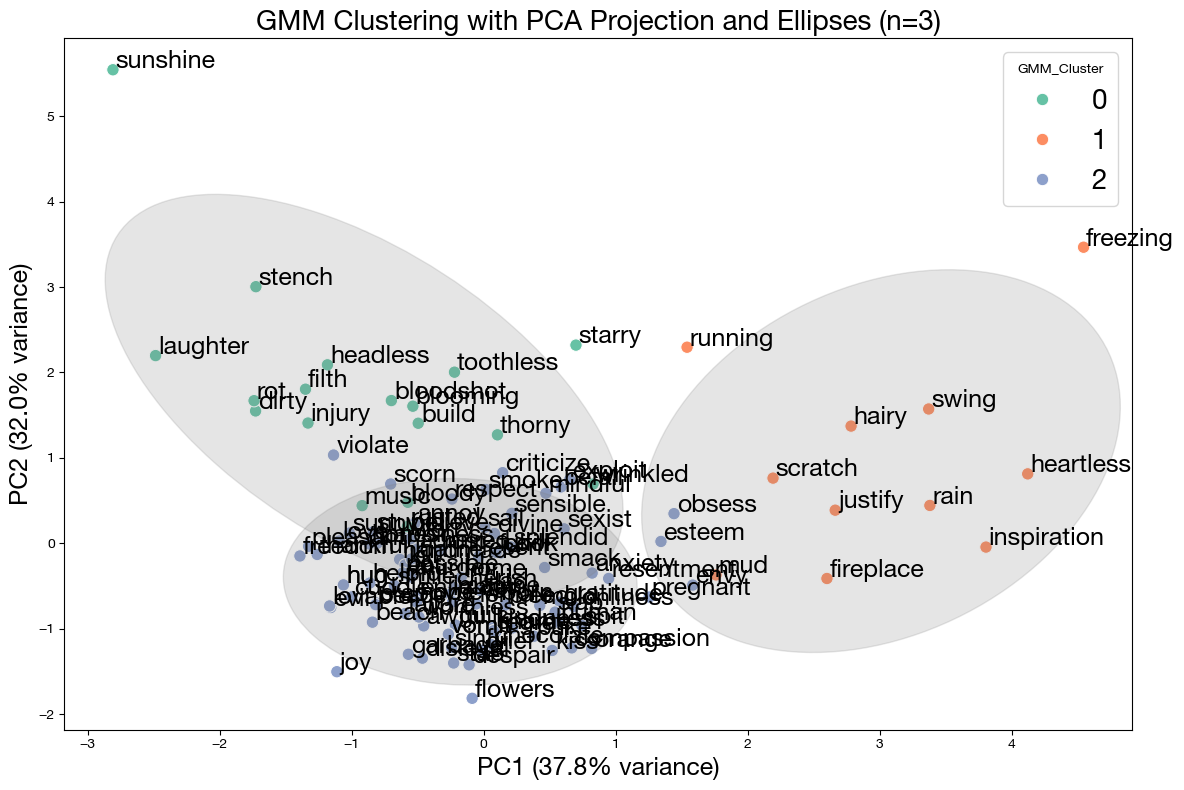

In [180]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax, **kwargs):
    """Draw an ellipse with a given position and covariance."""
    if covariance.shape == (2, 2):
        # Compute eigenvalues and eigenvectors
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 4 * np.sqrt(s)  # 2 SD ellipse
    else:
        width, height = 4 * np.sqrt(covariance)  # 2 SD for 1D case
        angle = 0

    ellipse = Ellipse(position, width, height, angle, **kwargs)
    ax.add_patch(ellipse)

# Create plot
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=wide, x='PC1', y='PC2', hue='GMM_Cluster', palette='Set2', s=80, ax=ax)

# Draw ellipses for each GMM cluster
for i in range(gmm.n_components):
    mean = gmm.means_[i]
    cov = gmm.covariances_[i]
    # Transform mean and covariance to PCA space
    mean_pca = pca.transform([mean])[0]
    cov_pca = pca.components_ @ cov @ pca.components_.T  # project cov to PCA space
    draw_ellipse(mean_pca, cov_pca, ax, alpha=0.2, color='gray')

# Add word labels
for i, row in wide.iterrows():
    ax.text(row['PC1'] + 0.02, row['PC2'] + 0.02, str(row['Word']), fontsize=18)

plt.title(f'GMM Clustering with PCA Projection and Ellipses (n={gmm.n_components})', fontsize=20)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=18)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=18)
plt.legend(title='GMM_Cluster', fontsize=20)
plt.tight_layout()
plt.savefig("../graphs/gmm_clusters_ellipses_plot.pdf", format='pdf')
plt.show()


## Do Valence and Concreteness predict the clustering?

### Chi-squared tests

In [229]:
import pandas as pd
from scipy.stats import chi2_contingency

# Valence

# Cross-tabulation
contingency_valence = pd.crosstab(wide['Valence'], wide['GMM_Cluster'])
print(contingency_valence)

# Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_valence)
print(f"Chi2: {chi2:.3f}, p-value: {p:.3f}")

# Concreteness
contingency_concrete = pd.crosstab(wide['Concreteness'], wide['GMM_Cluster'])
print(contingency_concrete)
chi2, p, dof, expected = chi2_contingency(contingency_concrete)
print(f"Chi2: {chi2:.3f}, p-value: {p:.3f}")


# Category
contingency_concrete = pd.crosstab(wide['Category'], wide['GMM_Cluster'])
print(contingency_concrete)
chi2, p, dof, expected = chi2_contingency(contingency_concrete)
print(f"Chi2: {chi2:.3f}, p-value: {p:.3f}")


GMM_Cluster   0  1   2
Valence               
negative     12  5  43
positive      6  6  48
Chi2: 2.366, p-value: 0.306
GMM_Cluster    0  1   2
Concreteness           
abstract       0  3  57
concrete      18  8  34
Chi2: 26.086, p-value: 0.000
GMM_Cluster   0  1   2
Category              
Adjs         10  3  27
Nouns         7  4  29
Verbs         1  4  35
Chi2: 8.325, p-value: 0.080


### Logistic Regression

In [186]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Make sure Valence and Concreteness are categorical
wide['Valence'] = wide['Valence'].astype('category')
wide['Concreteness'] = wide['Concreteness'].astype('category')

# Multinomial logistic regression: GMM_Cluster ~ Valence + Concreteness
model = smf.mnlogit('GMM_Cluster ~ Valence + Concreteness', data=wide)
result = model.fit()

print(result.summary())


         Current function value: 0.563021
         Iterations: 35
                          MNLogit Regression Results                          
Dep. Variable:            GMM_Cluster   No. Observations:                  120
Model:                        MNLogit   Df Residuals:                      114
Method:                           MLE   Df Model:                            4
Date:                Thu, 05 Jun 2025   Pseudo R-squ.:                  0.2108
Time:                        08:28:06   Log-Likelihood:                -67.563
converged:                      False   LL-Null:                       -85.607
Covariance Type:            nonrobust   LLR p-value:                 2.774e-07
           GMM_Cluster=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   28.6276   1.14e+06   2.52e-05      1.000   -2.23e+06    2.23e+06
Valence[T.positive]    

/Users/momo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [188]:
model_valence = smf.mnlogit('GMM_Cluster ~ Valence', data=wide).fit()
print(model_valence.summary())


Optimization terminated successfully.
         Current function value: 0.703374
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:            GMM_Cluster   No. Observations:                  120
Model:                        MNLogit   Df Residuals:                      116
Method:                           MLE   Df Model:                            2
Date:                Thu, 05 Jun 2025   Pseudo R-squ.:                 0.01404
Time:                        08:29:46   Log-Likelihood:                -84.405
converged:                       True   LL-Null:                       -85.607
Covariance Type:            nonrobust   LLR p-value:                    0.3005
      GMM_Cluster=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.8755      0.532     -1.645      0.100      -1.919       0.168
Va

In [189]:
model_concrete = smf.mnlogit('GMM_Cluster ~ Concreteness', data=wide).fit()
print(model_concrete.summary())


         Current function value: 0.575109
         Iterations: 35
                          MNLogit Regression Results                          
Dep. Variable:            GMM_Cluster   No. Observations:                  120
Model:                        MNLogit   Df Residuals:                      116
Method:                           MLE   Df Model:                            2
Date:                Thu, 05 Jun 2025   Pseudo R-squ.:                  0.1938
Time:                        08:29:49   Log-Likelihood:                -69.013
converged:                      False   LL-Null:                       -85.607
Covariance Type:            nonrobust   LLR p-value:                 6.212e-08
           GMM_Cluster=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   21.1636   2.28e+04      0.001      0.999   -4.46e+04    4.46e+04
Concreteness[T.concrete

/Users/momo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


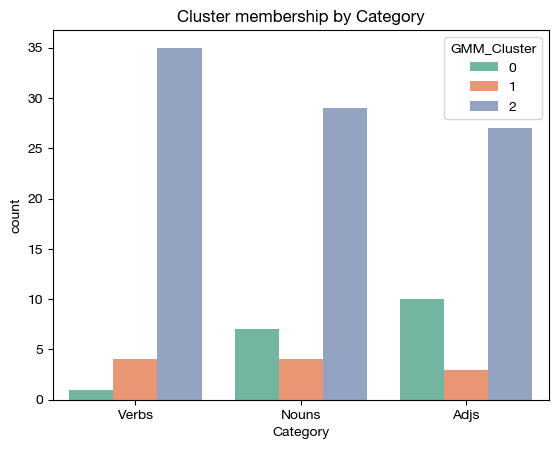

In [231]:
sns.countplot(x='Category', hue='GMM_Cluster', data=wide, palette='Set2')
plt.title('Cluster membership by Category')
plt.savefig("../graphs/gmm_clusters_by_category.pdf", format='pdf')
plt.show()

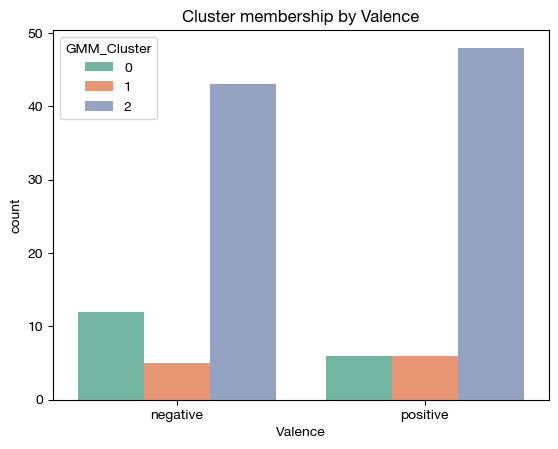

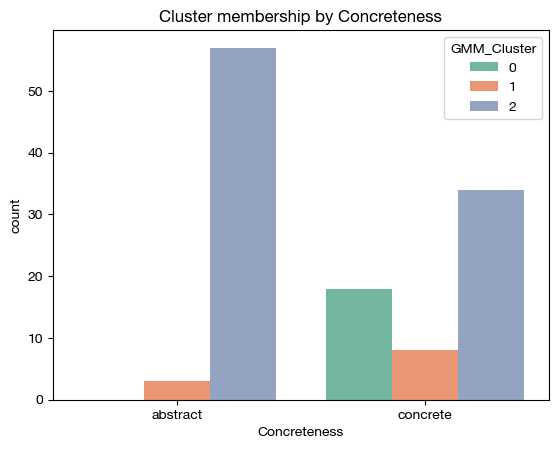

In [190]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Valence', hue='GMM_Cluster', data=wide, palette='Set2')
plt.title('Cluster membership by Valence')
plt.savefig("../graphs/gmm_clusters_by_valence.pdf", format='pdf')
plt.show()

sns.countplot(x='Concreteness', hue='GMM_Cluster', data=wide, palette='Set2')
plt.title('Cluster membership by Concreteness')
plt.savefig("../graphs/gmm_clusters_by_concrete.pdf", format='pdf')
plt.show()


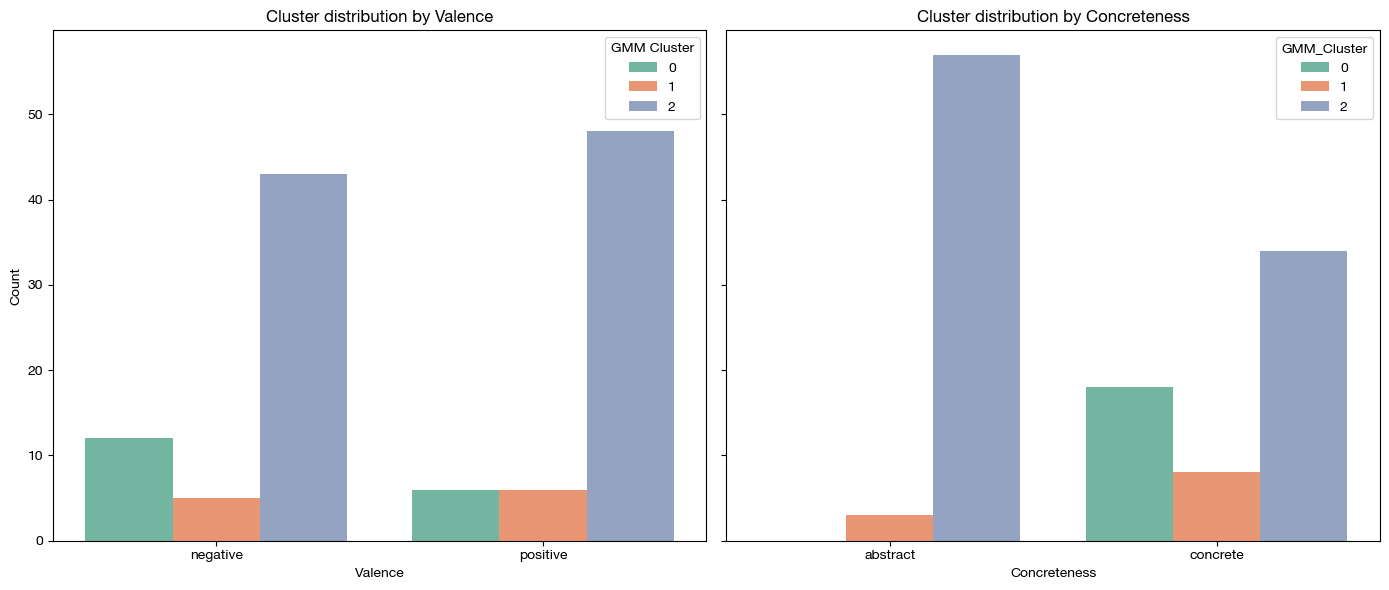

In [194]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot for Valence
sns.countplot(data=wide, x='Valence', hue='GMM_Cluster', palette='Set2', ax=axes[0])
axes[0].set_title('Cluster distribution by Valence')
axes[0].set_xlabel('Valence')
axes[0].set_ylabel('Count')
axes[0].legend(title='GMM Cluster')

# Plot for Concreteness
sns.countplot(data=wide, x='Concreteness', hue='GMM_Cluster', palette='Set2', ax=axes[1])
axes[1].set_title('Cluster distribution by Concreteness')
axes[1].set_xlabel('Concreteness')
axes[1].set_ylabel('')

# Improve layout
plt.tight_layout()
plt.show()


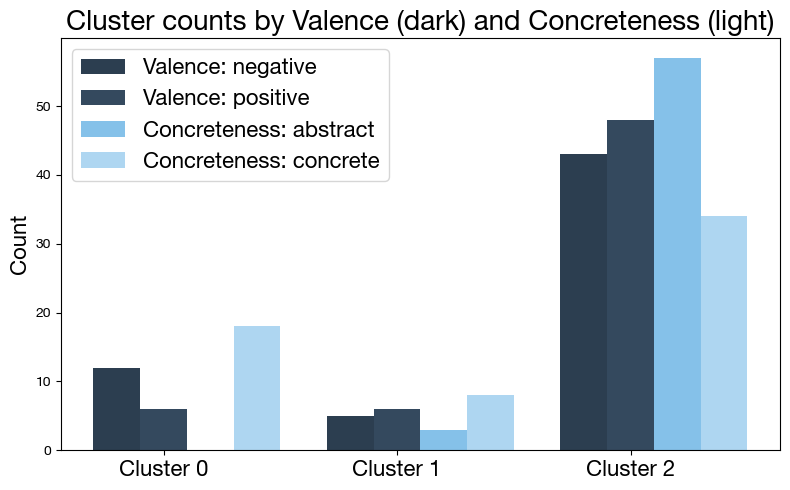

In [202]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Prepare counts for Valence and Concreteness per cluster
valence_counts = wide.groupby(['GMM_Cluster', 'Valence']).size().unstack(fill_value=0)
concreteness_counts = wide.groupby(['GMM_Cluster', 'Concreteness']).size().unstack(fill_value=0)

clusters = valence_counts.index.astype(str).tolist()
x = np.arange(len(clusters))  # the label locations

width = 0.4  # width of each bar
fig, ax = plt.subplots(figsize=(8, 5))  # smaller figure

# Plot Valence bars (darker colors)
colors_valence = ['#2c3e50', '#34495e']  # dark blues for Valence categories
for i, cat in enumerate(valence_counts.columns):
    ax.bar(x - width/2 + i*width/len(valence_counts.columns), valence_counts[cat], 
           width=width/len(valence_counts.columns), label=f'Valence: {cat}', color=colors_valence[i])

# Plot Concreteness bars (lighter colors)
colors_concreteness = ['#85c1e9', '#aed6f1']  # lighter blues for Concreteness categories
for i, cat in enumerate(concreteness_counts.columns):
    ax.bar(x + width/2 + i*width/len(concreteness_counts.columns), concreteness_counts[cat], 
           width=width/len(concreteness_counts.columns), label=f'Concreteness: {cat}', color=colors_concreteness[i])

# Labels and legend
ax.set_xticks(x)
ax.set_xticklabels([f'Cluster {c}' for c in clusters],fontsize=16)
ax.set_ylabel('Count',fontsize=16)
ax.set_title('Cluster counts by Valence (dark) and Concreteness (light)',fontsize=20)
ax.legend(fontsize=16)

plt.tight_layout()
plt.show()


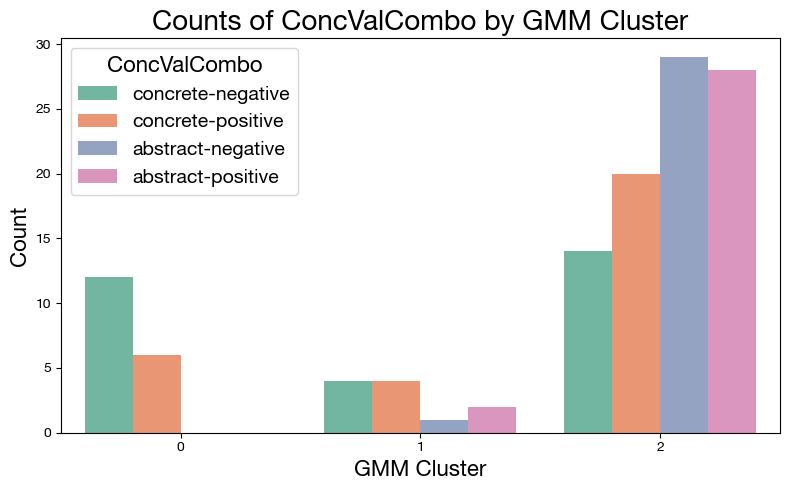

In [226]:
# Make sure ConcValCombo exists:
wide['ConcValCombo'] = wide['Concreteness'].astype(str) + '-' + wide['Valence'].astype(str)

# Count data for plotting
combo_counts = wide.groupby(['GMM_Cluster', 'ConcValCombo']).size().reset_index(name='Count')

plt.figure(figsize=(8, 5))
sns.barplot(data=combo_counts, x='GMM_Cluster', y='Count', hue='ConcValCombo', palette='Set2')

plt.title('Counts of ConcValCombo by GMM Cluster', fontsize=20)
plt.xlabel('GMM Cluster', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.legend(title='ConcValCombo', fontsize=14, title_fontsize=16, loc='best')
plt.tight_layout()
plt.savefig("../graphs/gmm_clusters_conc-val.pdf", format='pdf')
plt.show()


<Figure size 800x600 with 0 Axes>

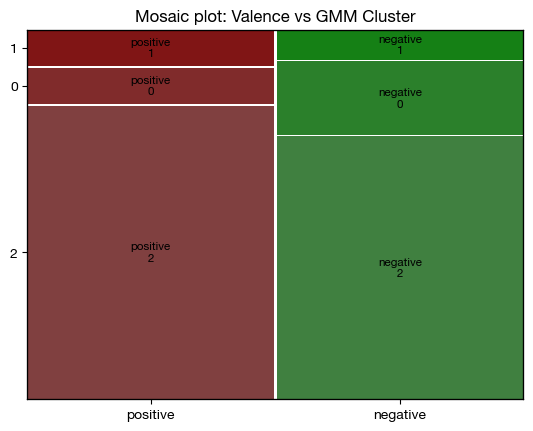

<Figure size 800x600 with 0 Axes>

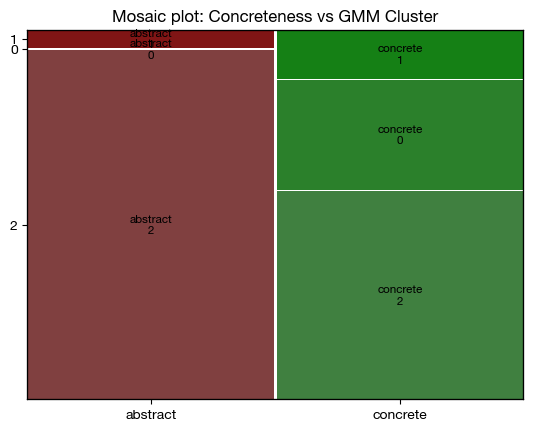

In [192]:
from statsmodels.graphics.mosaicplot import mosaic
import pandas as pd

# Valence mosaic
plt.figure(figsize=(8,6))
mosaic(wide, ['Valence', 'GMM_Cluster'], title='Mosaic plot: Valence vs GMM Cluster')
plt.show()

# Concreteness mosaic
plt.figure(figsize=(8,6))
mosaic(wide, ['Concreteness', 'GMM_Cluster'], title='Mosaic plot: Concreteness vs GMM Cluster')
plt.show()


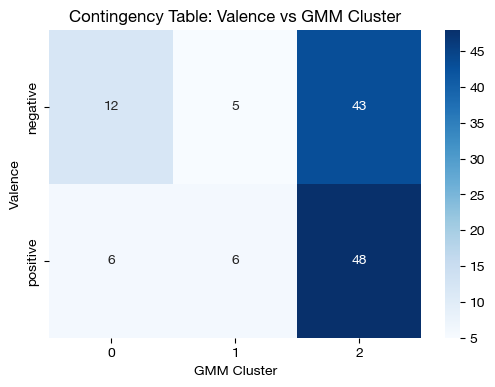

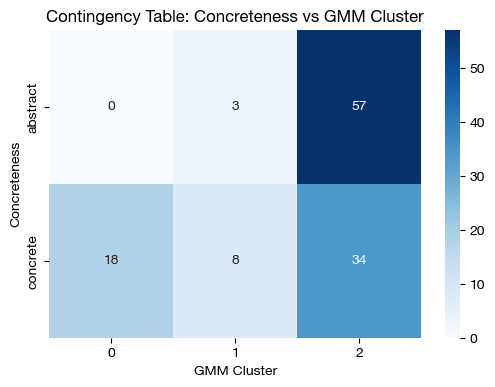

In [193]:
import numpy as np

# Valence contingency table
ct_valence = pd.crosstab(wide['Valence'], wide['GMM_Cluster'])

plt.figure(figsize=(6,4))
sns.heatmap(ct_valence, annot=True, fmt='d', cmap='Blues')
plt.title('Contingency Table: Valence vs GMM Cluster')
plt.xlabel('GMM Cluster')
plt.ylabel('Valence')
plt.show()

# Concreteness contingency table
ct_concrete = pd.crosstab(wide['Concreteness'], wide['GMM_Cluster'])

plt.figure(figsize=(6,4))
sns.heatmap(ct_concrete, annot=True, fmt='d', cmap='Blues')
plt.title('Contingency Table: Concreteness vs GMM Cluster')
plt.xlabel('GMM Cluster')
plt.ylabel('Concreteness')
plt.show()


# Try to find the best number of clusters

🔍 Lower BIC/AIC values indicate better model fit. The "elbow" or minimum point is usually the best choice.

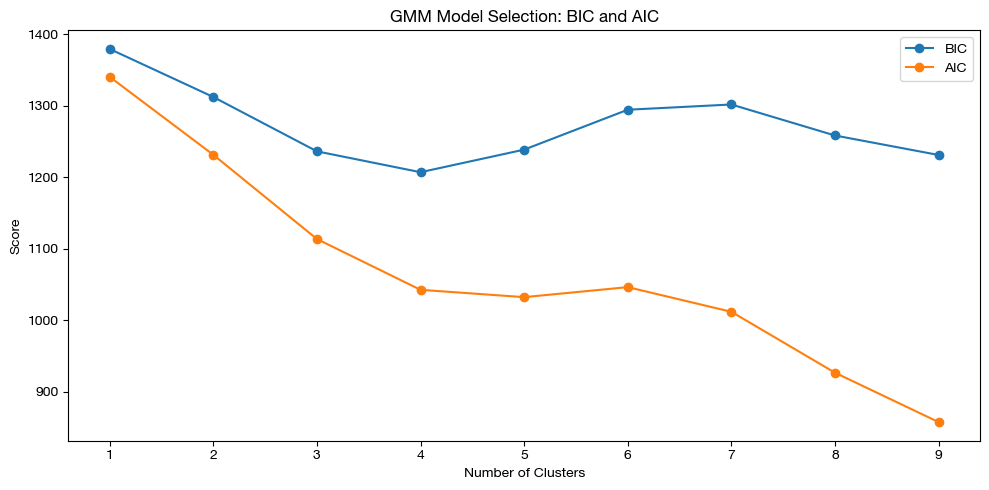

In [87]:
n_components_range = range(1, 10)  # Try 1 to 9 clusters
bics = []
aics = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X_scaled)
    bics.append(gmm.bic(X_scaled))
    aics.append(gmm.aic(X_scaled))

# Plot BIC and AIC
plt.figure(figsize=(10, 5))
plt.plot(n_components_range, bics, marker='o', label='BIC')
plt.plot(n_components_range, aics, marker='o', label='AIC')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('GMM Model Selection: BIC and AIC')
plt.legend()
plt.tight_layout()
plt.show()


## Fit GMM with best_n

PCA is applied to the scaled features (X_scaled), not the raw data.

Cluster colors reflect GMM-assigned labels.

The percentage in explained_variance_ratio_ tells you how much variance each principal component captures — useful for interpreting plot axes.

In [174]:
best_n = 4  # replace with your best value
gmm = GaussianMixture(n_components=best_n, random_state=42)
gmm.fit(X_scaled)
wide['GMM2_Cluster'] = gmm.predict(X_scaled)


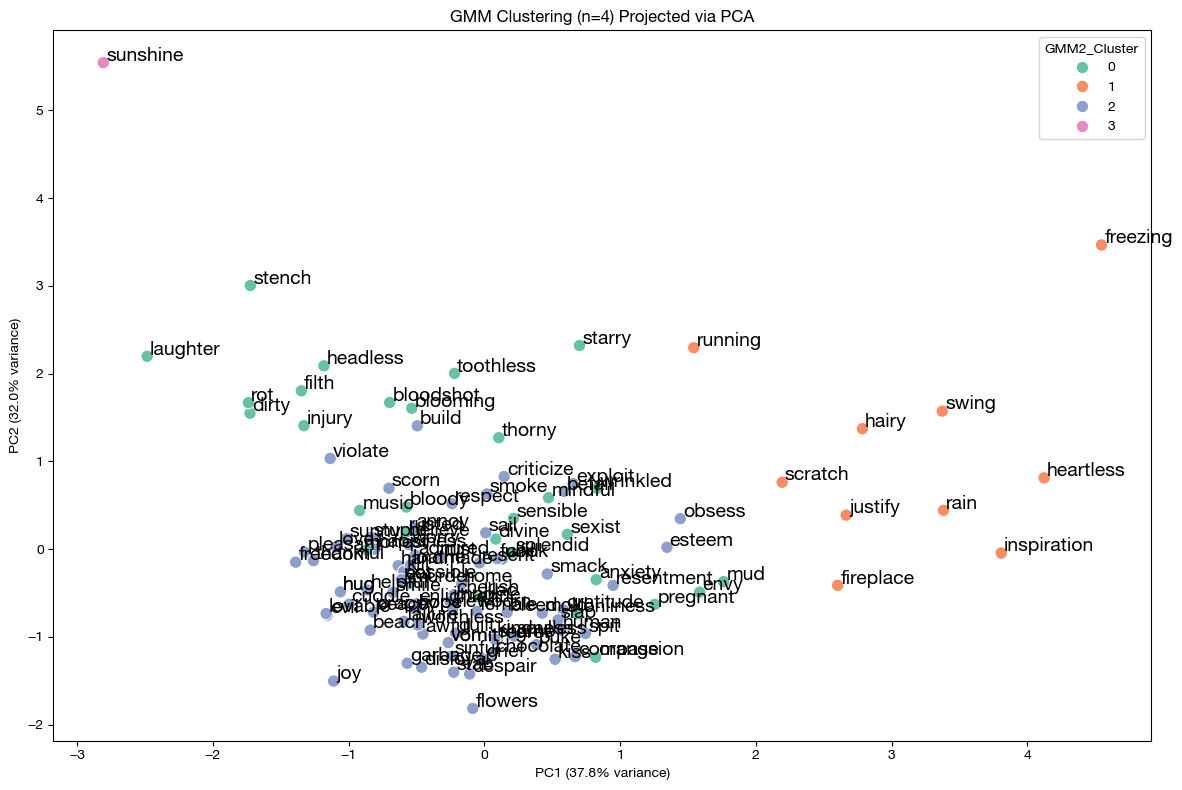

In [175]:

# Step 1: Apply PCA to the scaled data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 2: Add PCA coordinates to your dataframe
wide['PC1'] = X_pca[:, 0]
wide['PC2'] = X_pca[:, 1]

# Step 3: Plot the GMM clusters in PCA space
plt.figure(figsize=(12, 8))
sns.scatterplot(data=wide, x='PC1', y='PC2', palette="Set2", hue='GMM2_Cluster', s=80)

# Optionally add word labels
for i, row in wide.iterrows():
    plt.text(row['PC1'] + 0.02, row['PC2'] + 0.02, str(row['Word']), fontsize=14)

plt.title(f'GMM Clustering (n={gmm.n_components}) Projected via PCA')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.legend(title='GMM2_Cluster')
plt.tight_layout()
plt.show()


## Add Elipses to look at covariance


## Side-by-side GMM and Kmeans

95% CI ≈ 2 standard deviations (you can set n_std=2.0).

GMM ellipses show directional spread (anisotropic), while KMeans assumes equal spherical clusters.

Word labels help inspect cluster boundaries and ambiguous cases.

/var/folders/ng/p7mcfgw924986j7hgdgb5jg00000gn/T/ipykernel_43539/1615607807.py:33: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(position, width, height, angle, **kwargs)
/var/folders/ng/p7mcfgw924986j7hgdgb5jg00000gn/T/ipykernel_43539/1615607807.py:33: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(position, width, height, angle, **kwargs)
/var/folders/ng/p7mcfgw924986j7hgdgb5jg00000gn/T/ipykernel_43539/1615607807.py:33: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(position, width, height, angle, **kwargs)


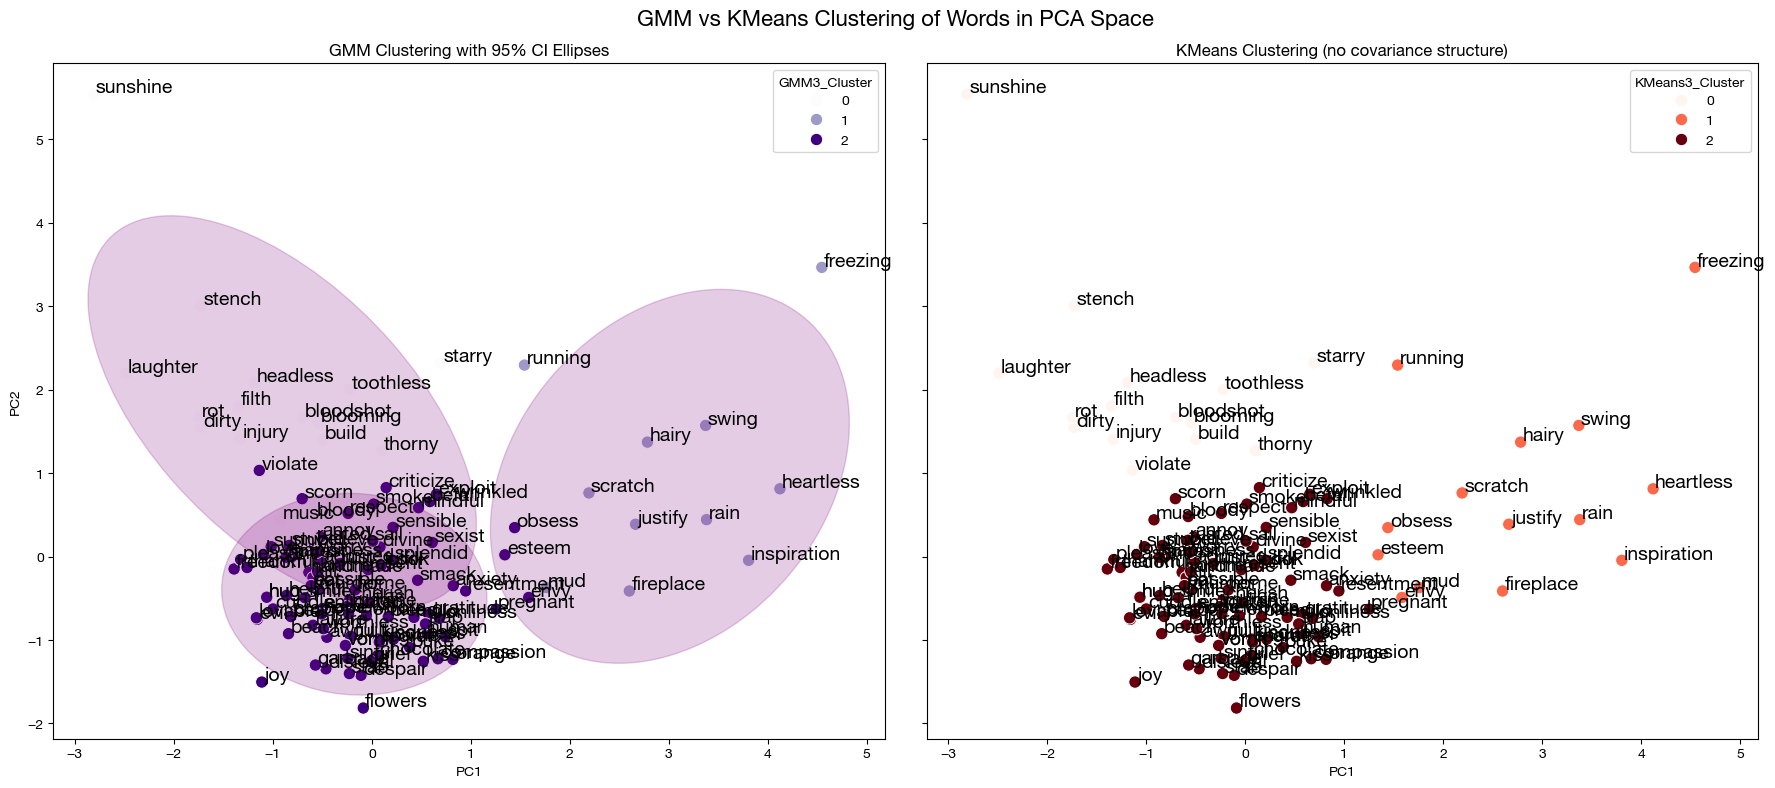

In [176]:
# ---- Prep Data ----
features = ['Mean_ReactionTime_Valence', 'Mean_Accuracy_Valence',
            'Mean_ReactionTime_Concrete', 'Mean_Accuracy_Concrete']

X = wide[features]
X_scaled = StandardScaler().fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
wide['PC1'] = X_pca[:, 0]
wide['PC2'] = X_pca[:, 1]

# ---- GMM ----
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X_scaled)
wide['GMM3_Cluster'] = gmm.predict(X_scaled)

# ---- KMeans ----
kmeans = KMeans(n_clusters=3, random_state=42)
wide['KMeans3_Cluster'] = kmeans.fit_predict(X_scaled)

# ---- Ellipse Drawing Function ----
def draw_ellipse(position, covariance, ax, n_std=2.0, **kwargs):
    """Draw an ellipse at position with covariance scaled by n_std standard deviations."""
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * n_std * np.sqrt(s)
    else:
        width, height = 2 * n_std * np.sqrt(covariance)
        angle = 0
    ellipse = Ellipse(position, width, height, angle, **kwargs)
    ax.add_patch(ellipse)

# ---- Plot Setup ----
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharex=True, sharey=True)

# ---- GMM Plot ----
sns.scatterplot(data=wide, x='PC1', y='PC2', hue='GMM3_Cluster', palette='Purples', s=80, ax=axes[0])
axes[0].set_title('GMM Clustering with 95% CI Ellipses')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

# Add ellipses for GMM
for i in range(gmm.n_components):
    mean = gmm.means_[i]
    cov = gmm.covariances_[i]
    mean_pca = pca.transform([mean])[0]
    cov_pca = pca.components_ @ cov @ pca.components_.T
    draw_ellipse(mean_pca, cov_pca, ax=axes[0], alpha=0.2, color='purple', n_std=2)

# Word labels
for i, row in wide.iterrows():
    axes[0].text(row['PC1'] + 0.02, row['PC2'] + 0.02, str(row['Word']), fontsize=14)

# ---- KMeans Plot ----
sns.scatterplot(data=wide, x='PC1', y='PC2', hue='KMeans3_Cluster', palette='Reds', s=80, ax=axes[1])
axes[1].set_title('KMeans Clustering (no covariance structure)')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('')

# Word labels
for i, row in wide.iterrows():
    axes[1].text(row['PC1'] + 0.02, row['PC2'] + 0.02, str(row['Word']), fontsize=14)

# Finalize
plt.suptitle('GMM vs KMeans Clustering of Words in PCA Space', fontsize=16)
plt.tight_layout()
plt.show()


In [98]:
# Print explained variance
explained = pca.explained_variance_ratio_
print(f"Explained Variance:\nPC1: {explained[0]*100:.2f}%, PC2: {explained[1]*100:.2f}%")


Explained Variance:
PC1: 37.82%, PC2: 32.00%


/var/folders/ng/p7mcfgw924986j7hgdgb5jg00000gn/T/ipykernel_43539/1615607807.py:33: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(position, width, height, angle, **kwargs)
/var/folders/ng/p7mcfgw924986j7hgdgb5jg00000gn/T/ipykernel_43539/1615607807.py:33: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(position, width, height, angle, **kwargs)
/var/folders/ng/p7mcfgw924986j7hgdgb5jg00000gn/T/ipykernel_43539/1615607807.py:33: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(position, width, height, angle, **kwargs)


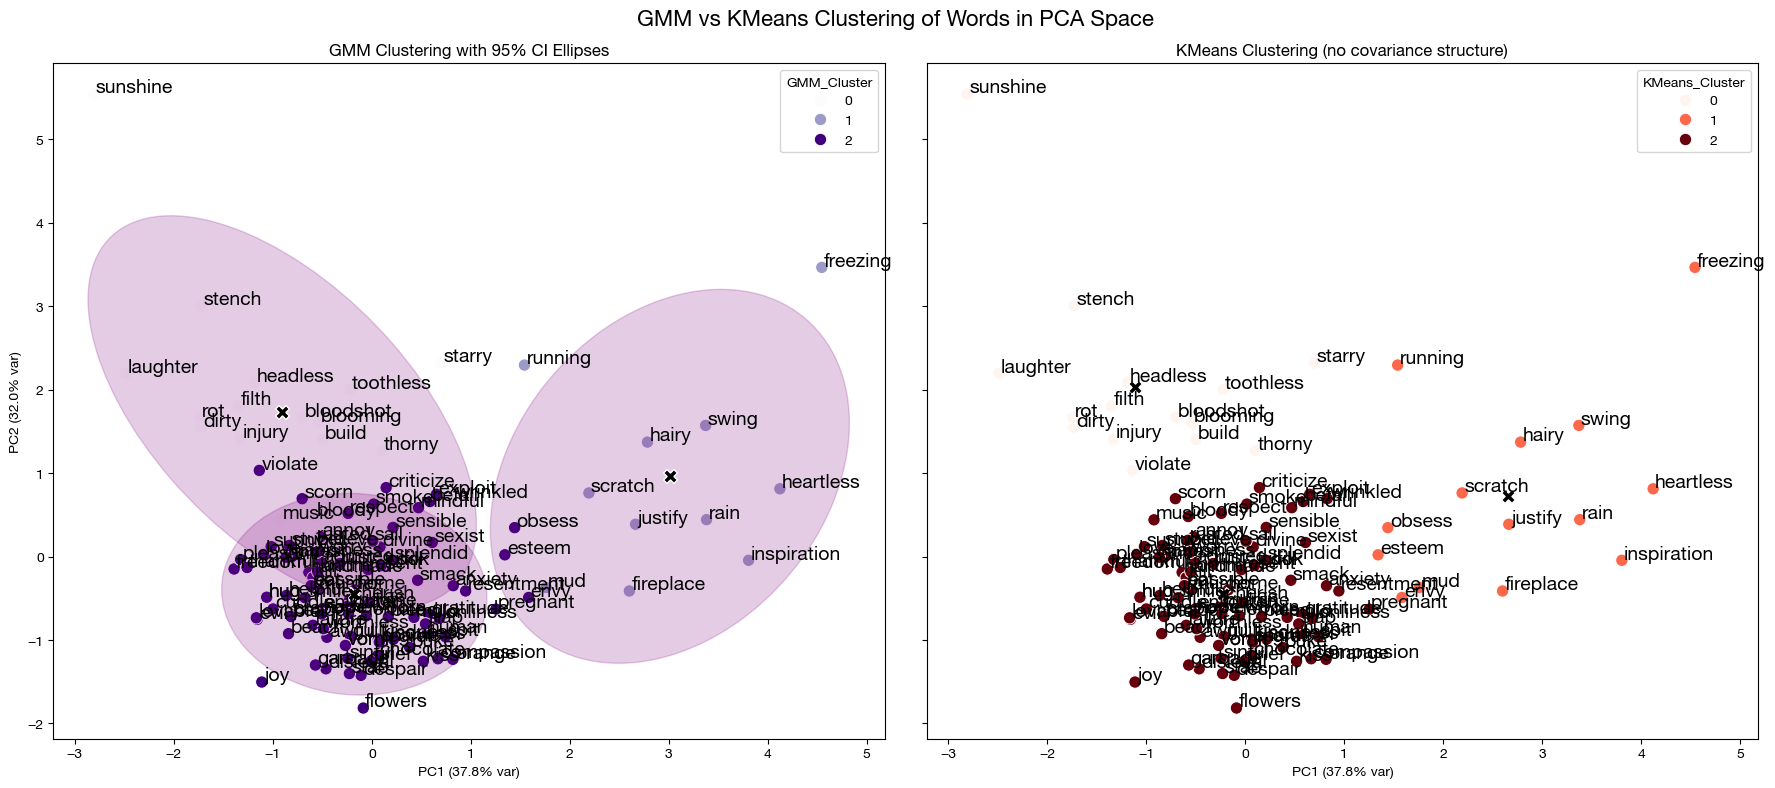

In [99]:
# ---- Plot Setup ----
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharex=True, sharey=True)

# ---- GMM Plot ----
sns.scatterplot(data=wide, x='PC1', y='PC2', hue='GMM_Cluster', palette='Purples', s=80, ax=axes[0])
axes[0].set_title('GMM Clustering with 95% CI Ellipses')
axes[0].set_xlabel(f'PC1 ({explained[0]*100:.1f}% var)')
axes[0].set_ylabel(f'PC2 ({explained[1]*100:.1f}% var)')

# Add ellipses and centroids for GMM
for i in range(gmm.n_components):
    mean = gmm.means_[i]
    cov = gmm.covariances_[i]
    mean_pca = pca.transform([mean])[0]
    cov_pca = pca.components_ @ cov @ pca.components_.T
    draw_ellipse(mean_pca, cov_pca, ax=axes[0], alpha=0.2, color='purple', n_std=2)
    axes[0].scatter(*mean_pca, color='black', marker='X', s=100, edgecolor='white')  # Centroid

# Word labels
for i, row in wide.iterrows():
    axes[0].text(row['PC1'] + 0.02, row['PC2'] + 0.02, str(row['Word']), fontsize=14)

# ---- KMeans Plot ----
sns.scatterplot(data=wide, x='PC1', y='PC2', hue='KMeans_Cluster', palette='Reds', s=80, ax=axes[1])
axes[1].set_title('KMeans Clustering (no covariance structure)')
axes[1].set_xlabel(f'PC1 ({explained[0]*100:.1f}% var)')
axes[1].set_ylabel('')

# Add centroids for KMeans
kmeans_centroids = pca.transform(kmeans.cluster_centers_)
axes[1].scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], color='black', marker='X', s=100, edgecolor='white')

# Word labels
for i, row in wide.iterrows():
    axes[1].text(row['PC1'] + 0.02, row['PC2'] + 0.02, str(row['Word']), fontsize=14)

# Finalize
plt.suptitle('GMM vs KMeans Clustering of Words in PCA Space', fontsize=16)
plt.tight_layout()
plt.show()


# Include Valence and concreteness

## GMM

In [237]:
# One-hot encode categorical variables
categorical_vars = ['Valence', 'Concreteness']
X_cat = pd.get_dummies(wide[categorical_vars], drop_first=True)

# Select numeric features
numeric_vars = ['Mean_ReactionTime_Valence', 'Mean_Accuracy_Valence',
                'Mean_ReactionTime_Concrete', 'Mean_Accuracy_Concrete']
X_num = wide[numeric_vars]

# Combine numeric and encoded categorical features
X_combined = pd.concat([X_num, X_cat], axis=1)

# Standardize all features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)


# Fit GMM with chosen number of components
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X_scaled)

# Assign clusters
wide['GMM_Cat_Cluster'] = gmm.predict(X_scaled)

# Optional: cluster probabilities
probs = gmm.predict_proba(X_scaled)


## Is valence or concreteness more important to clustering?

Larger differences in component means suggest a more influential feature.

If Concreteness_concrete varies more across clusters than Valence_positive, then Concreteness contributes more to separating the clusters.

In [253]:
# Create a DataFrame for the means of each feature by GMM component
feature_names = X_combined.columns
gmm_means_df = pd.DataFrame(gmm.means_, columns=feature_names)

# Look at how the dummy variables vary across clusters
print(gmm_means_df[['Valence_positive', 'Concreteness_concrete']])


   Valence_positive  Concreteness_concrete
0         -1.000000              -1.000000
1          1.000000               1.000000
2         -0.714301               1.000000
3         -0.005924               0.329384
4          1.000000              -1.000000
5         -1.000000               1.000000


### Interpretation:

A value near +1 or -1 means the cluster is very skewed toward that category (after standardization).

A value near 0 means the feature is not influential for that cluster (feature value close to overall mean).

➤ Valence_positive
Cluster 0: Strongly negative

Cluster 1: Strongly positive

Cluster 2: Moderately negative

Cluster 3: Neutral

Cluster 4: Strongly positive

Cluster 5: Strongly negative

🟩 Interpretation: Valence contributes to separation in multiple clusters, especially Cluster 1 (positive) and Cluster 0/5 (negative).

➤ Concreteness_concrete
Cluster 0: Strongly abstract

Cluster 1: Strongly concrete

Cluster 2: Strongly concrete

Cluster 3: Mildly concrete

Cluster 4: Strongly abstract

Cluster 5: Strongly concrete

🟦 Interpretation: Concreteness has more consistent influence, with several clusters being clearly concrete (1, 2, 5) or abstract (0, 4).


### Both features matter, but:

Concreteness shows a cleaner split between clusters (strong +1 or -1) across more clusters.

Valence varies more (some strong, some weak), so may be less dominant overall.

If you were to rank importance just from this analysis, Concreteness_concrete seems to play a more consistent role in distinguishing clusters.

In [254]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# Fit classifier to predict GMM clusters
clf = RandomForestClassifier(random_state=42)
clf.fit(X_combined, wide['GMM_Cat_Cluster'])

# Compute feature importance
result = permutation_importance(clf, X_combined, wide['GMM_Cat_Cluster'], n_repeats=10, random_state=42)
importance_df = pd.DataFrame({
    'feature': X_combined.columns,
    'importance': result.importances_mean
}).sort_values(by='importance', ascending=False)

print(importance_df)


                      feature  importance
4            Valence_positive    0.425833
5       Concreteness_concrete    0.217500
3      Mean_Accuracy_Concrete    0.068333
1       Mean_Accuracy_Valence    0.026667
2  Mean_ReactionTime_Concrete    0.020833
0   Mean_ReactionTime_Valence    0.008333


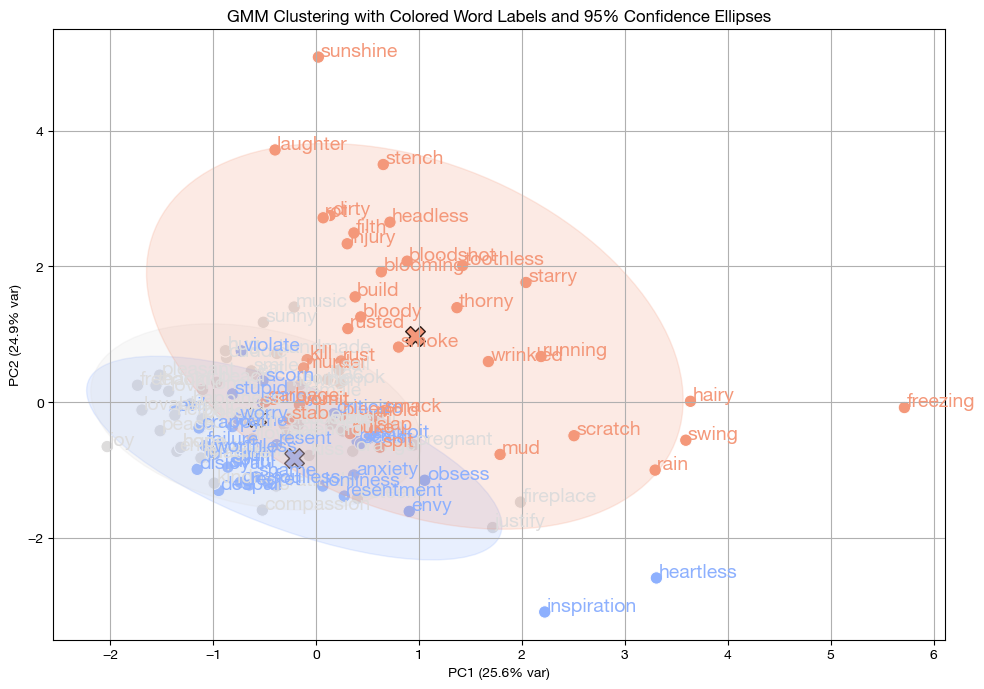

In [236]:

# PCA transformation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA and cluster info to the wide DataFrame
wide['PC1'] = X_pca[:, 0]
wide['PC2'] = X_pca[:, 1]

# Fit GMM and assign clusters
gmm = GaussianMixture(n_components=3, random_state=42)
wide['GMM_Cat_Cluster'] = gmm.fit_predict(X_scaled)

# Define palette and cluster color mapping
palette = sns.color_palette('coolwarm', wide['GMM_Cat_Cluster'].nunique())
cluster_colors = {cluster: palette[i] for i, cluster in enumerate(sorted(wide['GMM_Cat_Cluster'].unique()))}

# Calculate centroids and covariances
centroids = wide.groupby('GMM_Cat_Cluster')[['PC1', 'PC2']].mean()
covariances = {
    k: np.cov(wide[wide['GMM_Cat_Cluster'] == k][['PC1', 'PC2']].T)
    for k in centroids.index
}

# Start plot
plt.figure(figsize=(10, 7))
sns.scatterplot(data=wide, x='PC1', y='PC2', hue='GMM_Cat_Cluster', palette=palette, s=80, legend=False)

# Add word labels with matching colors
for _, row in wide.iterrows():
    cluster = row['GMM_Cat_Cluster']
    color = cluster_colors[cluster]
    plt.text(row['PC1'] + 0.02, row['PC2'] + 0.02, str(row['Word']), fontsize=14, color=color)

# Add centroids and ellipses
for cluster_id, centroid in centroids.iterrows():
    color = cluster_colors[cluster_id]
    
    # Centroid marker
    plt.scatter(*centroid, color=color, s=200, marker='X', edgecolor='black')
    
    # 95% CI ellipse
    cov = covariances[cluster_id]
    lambda_, v = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_)
    angle = np.degrees(np.arctan2(*v[:, 0][::-1]))
    
    ellipse = Ellipse(
        xy=centroid,
        width=2 * lambda_[0] * 1.96,
        height=2 * lambda_[1] * 1.96,
        angle=angle,
        color=color,
        alpha=0.2
    )
    plt.gca().add_patch(ellipse)

# Final formatting
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("GMM Clustering with Colored Word Labels and 95% Confidence Ellipses")
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/ng/p7mcfgw924986j7hgdgb5jg00000gn/T/ipykernel_43539/3818535507.py:12: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(position, width, height, angle, **kwargs)
/var/folders/ng/p7mcfgw924986j7hgdgb5jg00000gn/T/ipykernel_43539/3818535507.py:12: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(position, width, height, angle, **kwargs)
/var/folders/ng/p7mcfgw924986j7hgdgb5jg00000gn/T/ipykernel_43539/3818535507.py:12: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(position, width, height, angle, **kwargs)


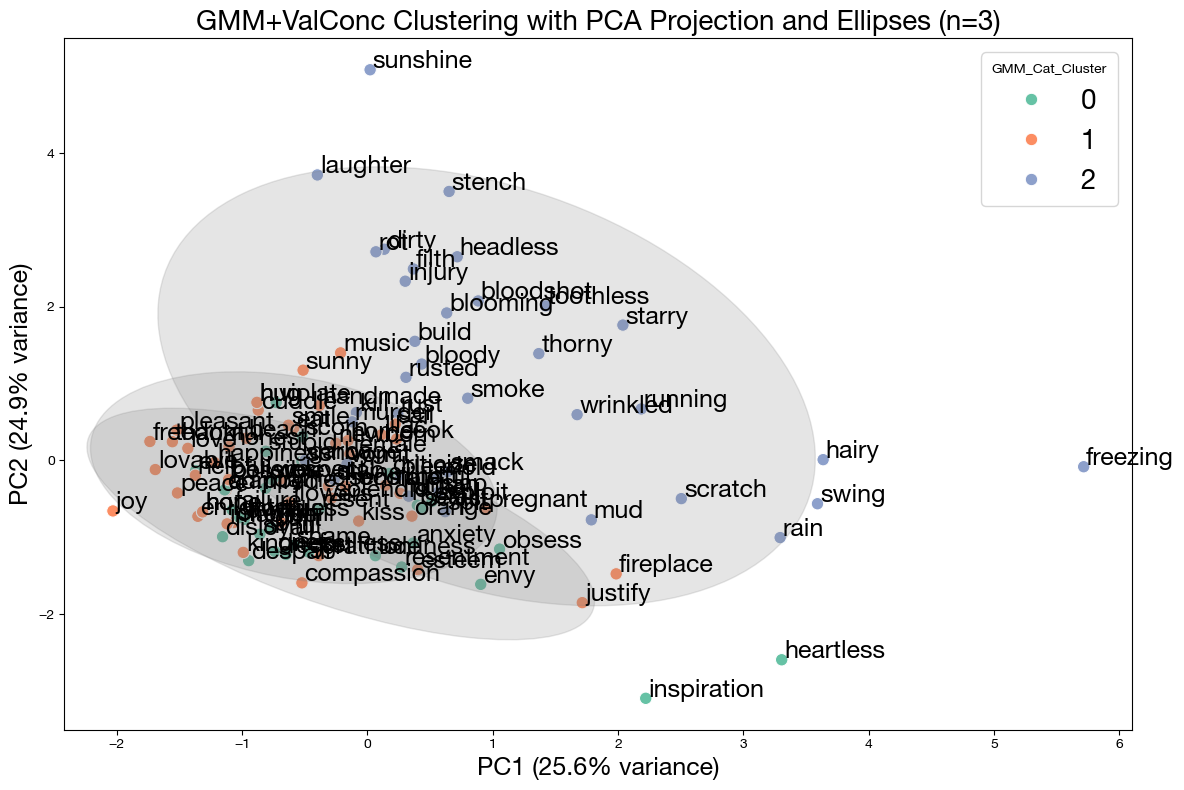

In [223]:

def draw_ellipse(position, covariance, ax, **kwargs):
    """Draw an ellipse with a given position and covariance."""
    if covariance.shape == (2, 2):
        # Compute eigenvalues and eigenvectors
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 4 * np.sqrt(s)  # 2 SD ellipse
    else:
        width, height = 4 * np.sqrt(covariance)  # 2 SD for 1D case
        angle = 0

    ellipse = Ellipse(position, width, height, angle, **kwargs)
    ax.add_patch(ellipse)

# Create plot
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=wide, x='PC1', y='PC2', hue='GMM_Cat_Cluster', palette='Set2', s=80, ax=ax)

# Draw ellipses for each GMM cluster
for i in range(gmm.n_components):
    mean = gmm.means_[i]
    cov = gmm.covariances_[i]
    # Transform mean and covariance to PCA space
    mean_pca = pca.transform([mean])[0]
    cov_pca = pca.components_ @ cov @ pca.components_.T  # project cov to PCA space
    draw_ellipse(mean_pca, cov_pca, ax, alpha=0.2, color='gray')

# Add word labels
for i, row in wide.iterrows():
    ax.text(row['PC1'] + 0.02, row['PC2'] + 0.02, str(row['Word']), fontsize=18)

plt.title(f'GMM+ValConc Clustering with PCA Projection and Ellipses (n={gmm.n_components})', fontsize=20)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=18)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=18)
plt.legend(title='GMM_Cat_Cluster', fontsize=20)
plt.tight_layout()
plt.savefig("../graphs/gmm_cat_clusters_ellipses_plot.pdf", format='pdf')
plt.show()


### Compute the best number of clusters

In [239]:
for k in range(1, 7):
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_scaled)
    print(f"k={k} BIC={gmm.bic(X_scaled):.2f}, AIC={gmm.aic(X_scaled):.2f}")


k=1 BIC=2096.24, AIC=2020.97
k=2 BIC=577.11, AIC=423.80
k=3 BIC=518.67, AIC=287.31
k=4 BIC=-78.92, AIC=-388.33
k=5 BIC=-67.85, AIC=-455.31
k=6 BIC=-539.84, AIC=-1005.35


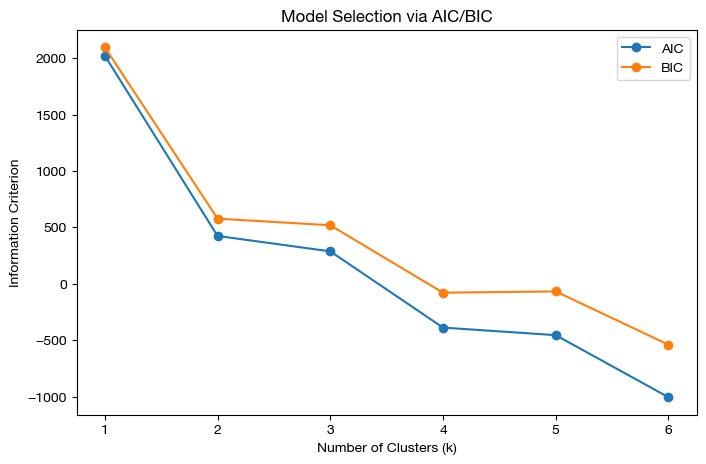

In [240]:

aics, bics = [], []
ks = range(1, 7)


for k in ks:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_scaled)
    aics.append(gmm.aic(X_scaled))
    bics.append(gmm.bic(X_scaled))

plt.figure(figsize=(8, 5))
plt.plot(ks, aics, label='AIC', marker='o')
plt.plot(ks, bics, label='BIC', marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Information Criterion")
plt.title("Model Selection via AIC/BIC")
plt.legend()
plt.show()


In [224]:

# Group by cluster and print as a table with categorical Valence and Concreteness
for cluster_id, cluster_group in wide.groupby('GMM_Cat_Cluster'):
    print(f"\nCluster {cluster_id} ({len(cluster_group)} words):")
    print(f"{'Valence / Concreteness':<30} | Words")
    print("-" * 70)

    grouped = cluster_group.groupby(['Valence', 'Concreteness'])
    for (valence, concreteness), group in grouped:
        val_conc = f"{valence} / {concreteness}"
        words = ", ".join(sorted(group['Word'].astype(str)))
        print(f"{val_conc:<30} | {words}")



Cluster 0 (31 words):
Valence / Concreteness         | Words
----------------------------------------------------------------------
negative / abstract            | annoy, anxiety, awful, befall, crappy, criticize, despair, disloyal, envy, evil, exploit, failure, grief, guilt, heartless, loathe, lonliness, obsess, regret, resent, resentment, scorn, sexist, shame, sinful, soulless, stupid, violate, worry, worthless
positive / abstract            | inspiration

Cluster 1 (51 words):
Valence / Concreteness         | Words
----------------------------------------------------------------------
positive / abstract            | admired, believe, cherish, compassion, divine, enlighten, esteem, freedom, fulfill, gratitude, happiness, helpful, honest, hope, hope, imagine, joy, justify, kindness, lovable, love, mindful, peace, pleasant, possible, respect, sensible, splendid, thankful
positive / concrete            | beach, chocolate, cook, cuddle, eat, female, fireplace, flowers, handmade, home,

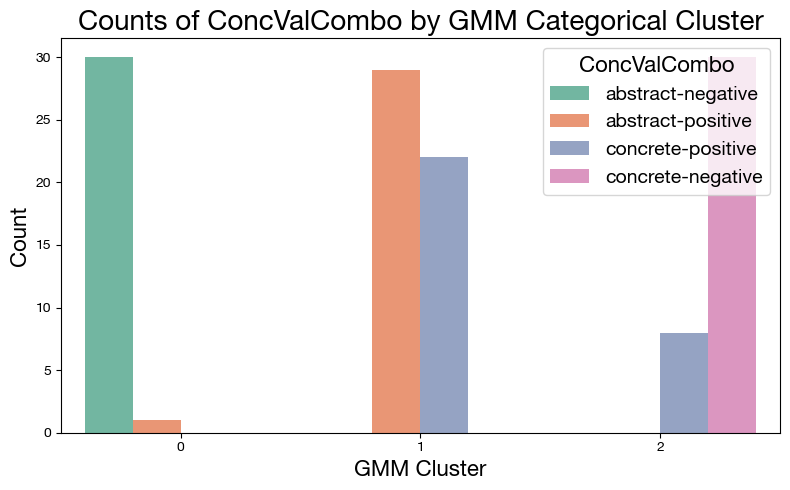

In [227]:
# Count data for plotting
combo_counts = wide.groupby(['GMM_Cat_Cluster', 'ConcValCombo']).size().reset_index(name='Count')

plt.figure(figsize=(8, 5))
sns.barplot(data=combo_counts, x='GMM_Cat_Cluster', y='Count', hue='ConcValCombo', palette='Set2')

plt.title('Counts of ConcValCombo by GMM Categorical Cluster', fontsize=20)
plt.xlabel('GMM Cluster', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.legend(title='ConcValCombo', fontsize=14, title_fontsize=16, loc='best')
plt.tight_layout()
plt.savefig("../graphs/gmm_cat_clusters_conc-val.pdf", format='pdf')
plt.show()

In [233]:
# Category
contingency_concrete = pd.crosstab(wide['Category'], wide['GMM_Cat_Cluster'])
print(contingency_concrete)
chi2, p, dof, expected = chi2_contingency(contingency_concrete)
print(f"Chi2: {chi2:.3f}, p-value: {p:.3f}")

GMM_Cat_Cluster   0   1   2
Category                   
Adjs             10  18  12
Nouns            11  16  13
Verbs            10  17  13
Chi2: 0.235, p-value: 0.994


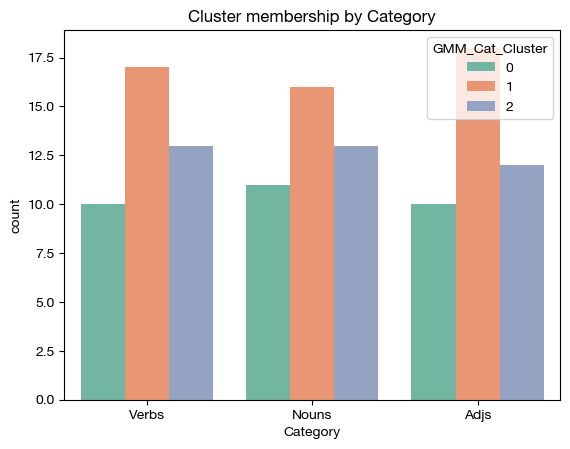

In [232]:
sns.countplot(x='Category', hue='GMM_Cat_Cluster', data=wide, palette='Set2')
plt.title('Cluster membership by Category')
plt.savefig("../graphs/gmm_cat_clusters_by_category.pdf", format='pdf')
plt.show()

## Evaluate model fit (AIC and BIC)

What they measure: Both are metrics that evaluate model quality by balancing model fit and complexity (number of parameters).

How to interpret:

Lower values indicate a better model.

When you plot AIC/BIC against the number of clusters, look for the "elbow" point or minimum value.

This helps you choose the optimal number of clusters without overfitting.

BIC tends to penalize complexity more harshly than AIC, so BIC often favors simpler models.

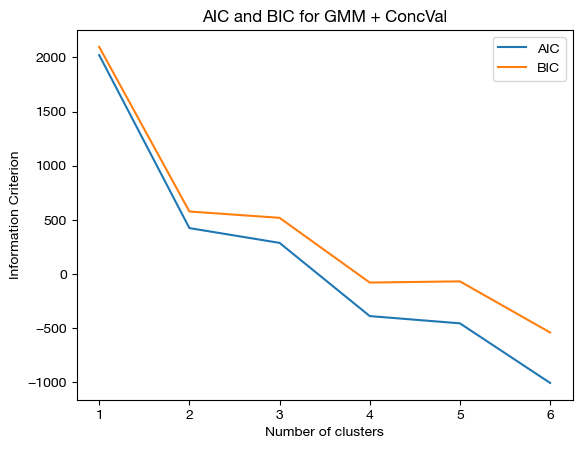

In [242]:
n_components = range(1, 7)
aic = []
bic = []

for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X_scaled)
    aic.append(gmm.aic(X_scaled))
    bic.append(gmm.bic(X_scaled))

plt.plot(n_components, aic, label='AIC')
plt.plot(n_components, bic, label='BIC')
plt.xlabel('Number of clusters')
plt.ylabel('Information Criterion')
plt.legend()
plt.title('AIC and BIC for GMM + ConcVal')
plt.show()


## Cluster Assignment uncertainty (Max Posterior Prob point-wise)

What it measures: For each data point, the highest probability assigned to any cluster (i.e., how confidently the model classifies the point).

How to interpret:

Values close to 1 mean the point clearly belongs to one cluster (low uncertainty).

Values closer to 0.5 or lower mean the model is uncertain, the point might lie between clusters or in overlapping regions.

A histogram skewed towards high probabilities indicates well-separated clusters.

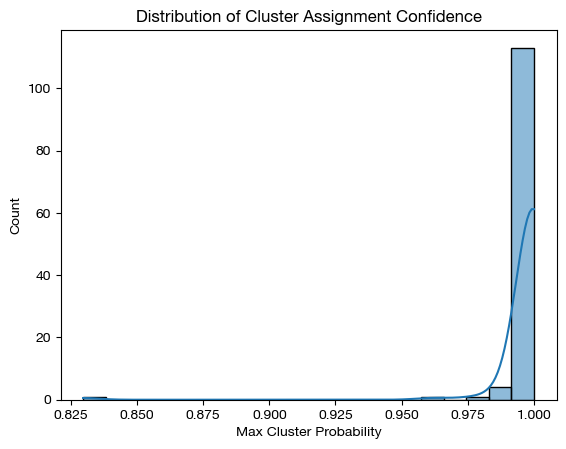

In [243]:
max_probs = probs.max(axis=1)

sns.histplot(max_probs, bins=20, kde=True)
plt.xlabel('Max Cluster Probability')
plt.title('Distribution of Cluster Assignment Confidence')
plt.show()


## Cluster size distribution

What it measures: Number of points assigned to each cluster.

How to interpret:

Balanced cluster sizes often indicate meaningful partitions.

Very small clusters might indicate outliers or noise, or an overly complex model.

Very large clusters with a few tiny ones might mean the model isn’t capturing finer structure or that some clusters are merging.

In [244]:
print(wide['GMM_Cat_Cluster'].value_counts())


GMM_Cat_Cluster
1    51
2    38
0    31
Name: count, dtype: int64


## Model Parameters

Means: The centroid of each Gaussian in feature space (after scaling).

Interpretation: Differences in means tell you how clusters differ along each feature.

Covariances: How spread out each cluster is and how features relate to each other within clusters.

Interpretation: Large covariance means a cluster is more spread; off-diagonal values indicate correlations between features in that cluster.

In [245]:
print("Means of each cluster (in scaled feature space):")
print(gmm.means_)

print("\nCovariances of each cluster:")
print(gmm.covariances_)


Means of each cluster (in scaled feature space):
[[-3.53836910e-02  1.99610394e-01 -7.80772963e-02  3.91094487e-01
  -1.00000000e+00 -1.00000000e+00]
 [-1.39285349e-01 -9.29637334e-02 -2.41794079e-01  9.48901279e-02
   1.00000000e+00  1.00000000e+00]
 [-4.23331808e-01  1.59145279e-01  7.73334264e-01 -2.14296589e+00
  -7.14300595e-01  1.00000000e+00]
 [ 2.55460518e+00 -2.56484371e+00  4.00396497e-01 -1.53560745e-02
  -5.92427682e-03  3.29383815e-01]
 [-1.91715356e-01  3.35682776e-01  5.18502810e-03  2.46995523e-01
   1.00000000e+00 -1.00000000e+00]
 [ 5.63464854e-02 -2.04775206e-03 -3.00369409e-01  5.69888044e-01
  -1.00000000e+00  1.00000000e+00]]

Covariances of each cluster:
[[[ 3.54803996e-01 -1.25697887e-01  1.85960688e-01 -1.22634851e-02
    1.48761485e-33  1.48761485e-33]
  [-1.25697887e-01  4.12057030e-01  9.65908594e-02 -6.33912478e-02
   -4.25032815e-34 -4.25032815e-34]
  [ 1.85960688e-01  9.65908594e-02  5.58913580e-01 -1.69535517e-01
    4.88787738e-33  4.88787738e-33]
  [-1

## Silhouette score

What it measures: How similar a point is to its own cluster compared to other clusters.

How to interpret:

Values range from -1 to 1.

Close to 1 = well-clustered; points are closer to their own cluster than to others.

Near 0 = points on the boundary between clusters.

Negative values = points may be assigned to the wrong cluster.

Though originally for hard clustering (like k-means), it can still give a rough idea of cluster separation for GMM clusters assigned by hard labels.

In [246]:

score = silhouette_score(X_scaled, wide['GMM_Cat_Cluster'])
print(f'Silhouette Score: {score:.3f}')


Silhouette Score: 0.224


# Compare the two models, GMM without ValCon and GMM with

## Contingency table
This shows how points are assigned across clusters in each model.

Diagonal dominance = strong agreement.

Off-diagonal values = disagreement.


In [251]:
pd.crosstab(wide['GMM_Cluster'], wide['GMM_Cat_Cluster'])


GMM_Cat_Cluster,0,1,2
GMM_Cluster,,,
0,0,1,17
1,2,2,7
2,29,48,14


### Interpretation

Low consistency between the two clusterings.

Possibly:

GMM_Cat_Cluster (based on categorical variables) is uncovering structure missed by the continuous-variable-based GMM.

Or, GMM_Cluster is grouping based on patterns irrelevant to the categorical split.

These are qualitatively different clusterings, not just permutations of each other.



##  Normalized Mutual Information

Measures how much information the two clusterings share (range 0 to 1).

A symmetric score (range: 0 to 1) measuring how much information one clustering shares with the other.

What it tells you:
NMI = 1: perfect clustering agreement.

NMI = 0: no shared information — they’re independent.

It’s robust to label permutations (i.e., Cluster 0 in one model doesn’t have to be Cluster 0 in the other).


In [247]:
from sklearn.metrics import normalized_mutual_info_score

nmi = normalized_mutual_info_score(wide['GMM_Cluster'], wide['GMM_Cat_Cluster'])
print(f'Normalized Mutual Information (NMI): {nmi:.3f}')


Normalized Mutual Information (NMI): 0.236


### Interpretation

There’s limited agreement between the two models.

The clusterings capture different underlying structure in the data.

## Adjusted Rand Index

Measures how well the pairwise membership decisions match between the two clusterings.

What it tells you:
ARI = 1: perfect agreement.

ARI = 0: clustering no better than random.

ARI < 0: worse than random (rare).

Difference from NMI:
ARI considers exact pairwise matching.

More sensitive to small differences or cluster splits/merges.

In [248]:
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(wide['GMM_Cluster'], wide['GMM_Cat_Cluster'])
print(f'Adjusted Rand Index (ARI): {ari:.3f}')


Adjusted Rand Index (ARI): 0.164


### Interpretation

There is some mild agreement, but it's barely above chance.

The two clusterings (from GMM_Cluster and GMM_Cat_Cluster) are largely dissimilar in how they assign data points.

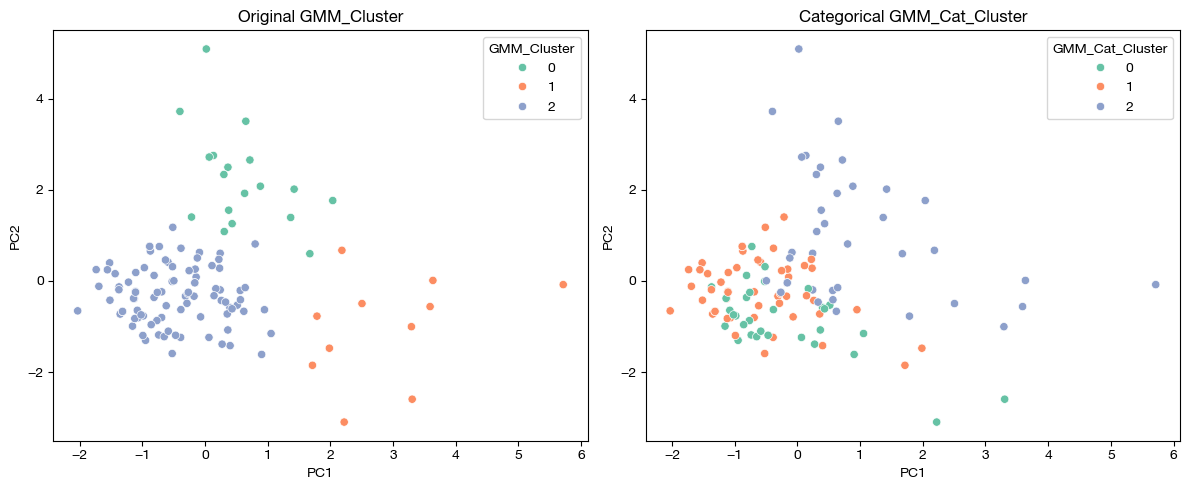

In [249]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(data=wide, x='PC1', y='PC2', hue='GMM_Cluster', palette='Set2', ax=axes[0])
axes[0].set_title('Original GMM_Cluster')

sns.scatterplot(data=wide, x='PC1', y='PC2', hue='GMM_Cat_Cluster', palette='Set2', ax=axes[1])
axes[1].set_title('Categorical GMM_Cat_Cluster')

plt.tight_layout()
plt.show()


## Cluster proportions

What it tells you:
Whether one model created a more balanced or dominant clustering.

Large imbalance might reflect:

An overfit model (one large catch-all cluster).

Real-world structure (if grounded in domain knowledge).

In [250]:
print("GMM_Cluster proportions:")
print(wide['GMM_Cluster'].value_counts(normalize=True))

print("\nGMM_Cat_Cluster proportions:")
print(wide['GMM_Cat_Cluster'].value_counts(normalize=True))


GMM_Cluster proportions:
GMM_Cluster
2    0.758333
0    0.150000
1    0.091667
Name: proportion, dtype: float64

GMM_Cat_Cluster proportions:
GMM_Cat_Cluster
1    0.425000
2    0.316667
0    0.258333
Name: proportion, dtype: float64


### Interpretation

GMM_Cluster:

Heavily imbalanced: one cluster dominates the assignment.

Suggests that GMM found a "catch-all" cluster (Cluster 2) that includes most of the data — possibly due to overlapping distributions or low separability in PCA space.

This clustering may be less granular, emphasizing similarity over differentiation.


GMM_Cat_Cluster:
Much more balanced: each cluster has ~25–43% of the data.

Indicates the model is differentiating more cleanly among categories (Valence/Concreteness).

Suggests that the categorical GMM is better at carving up the data space into distinct subgroups.


# Do certain word features predict the clusters?

In [36]:


# X = pd.get_dummies(wide[['Valence', 'Concreteness']], drop_first=True)


In [111]:


# Define your target (GMM or KMeans cluster labels)
y = wide['GMM_Cluster']  # or use wide['KMeans_Cluster']

# Select predictors
predictors = ['Valence', 'Concreteness','Category']

# One-hot encode categorical features
X = pd.get_dummies(wide[predictors], drop_first=True)

# Fit classifier and cross-validate
clf = RandomForestClassifier(random_state=42)
scores = cross_val_score(clf, X, y, cv=5)

# Output model performance
print(f"Mean CV accuracy: {scores.mean():.2f}")


Mean CV accuracy: 0.93


In [112]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import pandas as pd

# Define your cluster labels (target)
y = wide['GMM_Cluster']  # or use 'KMeans_Cluster'

# Define predictor sets
predictor_sets = {
    "All": ['Valence', 'Concreteness', 'Category'],
    "Val+Conc": ['Valence', 'Concreteness'],
    "ValOnly": ['Valence'],
    "ConcOnly": ['Concreteness']
}

# Compare model performance
results = {}

for name, predictors in predictor_sets.items():
    # One-hot encode categorical features
    X = pd.get_dummies(wide[predictors], drop_first=True)
    
    # Train and evaluate classifier
    clf = RandomForestClassifier(random_state=42)
    scores = cross_val_score(clf, X, y, cv=5)
    
    results[name] = scores.mean()
    print(f"{name} — Mean CV Accuracy: {scores.mean():.3f}")


All — Mean CV Accuracy: 0.925
Val+Conc — Mean CV Accuracy: 0.925
ValOnly — Mean CV Accuracy: 0.658
ConcOnly — Mean CV Accuracy: 0.575


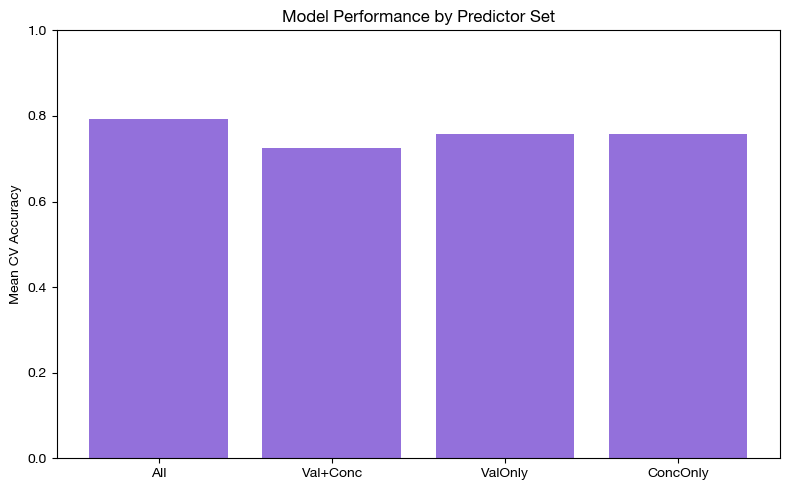

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(results.keys(), results.values(), color='mediumpurple')
plt.ylabel("Mean CV Accuracy")
plt.title("Model Performance by Predictor Set")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


All — Accuracy: 0.667


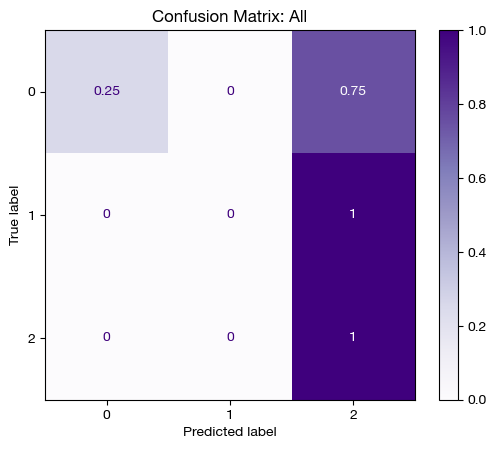

Val+Conc — Accuracy: 0.583


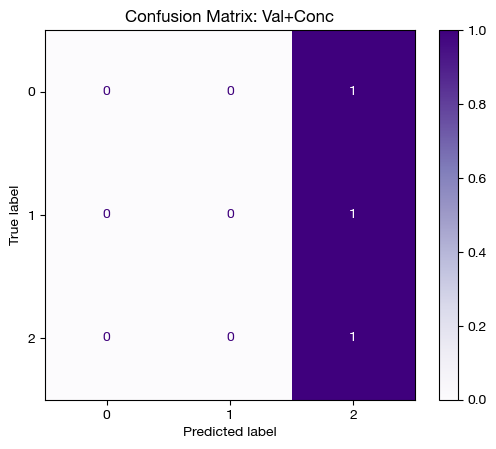

ValOnly — Accuracy: 0.583


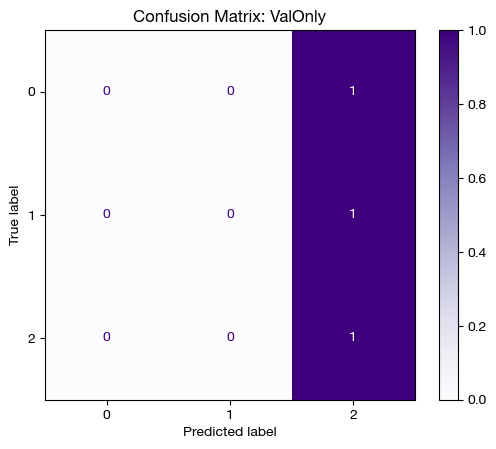

ConcOnly — Accuracy: 0.583


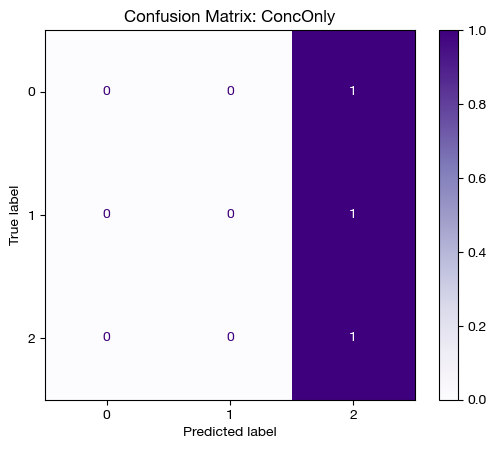

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd

# Define target
y = wide['GMM_Cluster']  # or 'KMeans_Cluster'

# Predictor sets
predictor_sets = {
    "All": ['Valence', 'Concreteness', 'Category'],
    "Val+Conc": ['Valence', 'Concreteness'],
    "ValOnly": ['Valence'],
    "ConcOnly": ['Concreteness']
}

# Store results
results = {}

# Loop over each set
for name, predictors in predictor_sets.items():
    # One-hot encode predictors
    X = pd.get_dummies(wide[predictors], drop_first=True)

    # Split train/test (80/20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)

    # Predict
    y_pred = clf.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} — Accuracy: {acc:.3f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize='true')  # row-normalized
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap='Purples')
    plt.title(f"Confusion Matrix: {name}")
    plt.show()


All — Logistic Regression Accuracy: 0.792


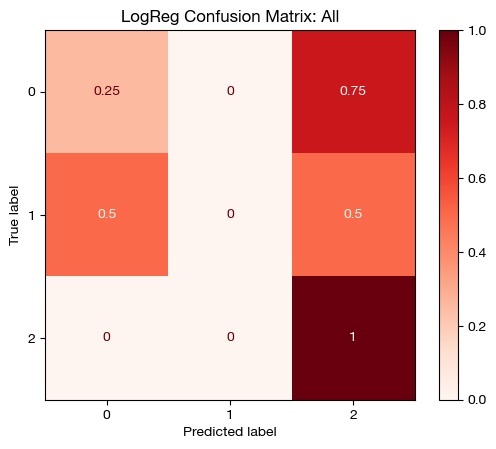

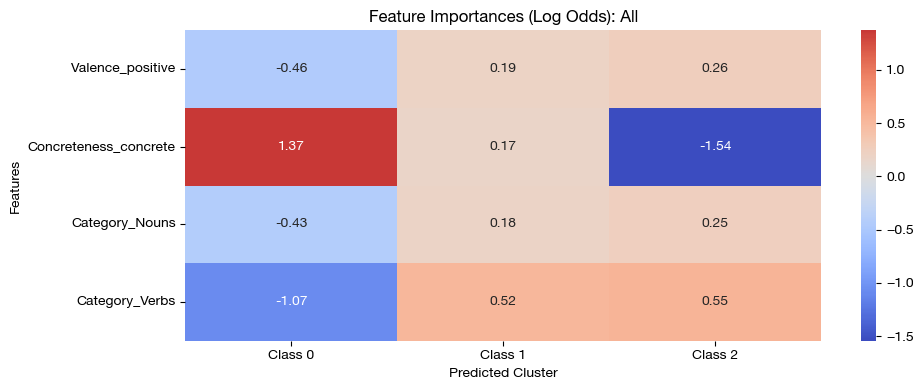

Val+Conc — Logistic Regression Accuracy: 0.750


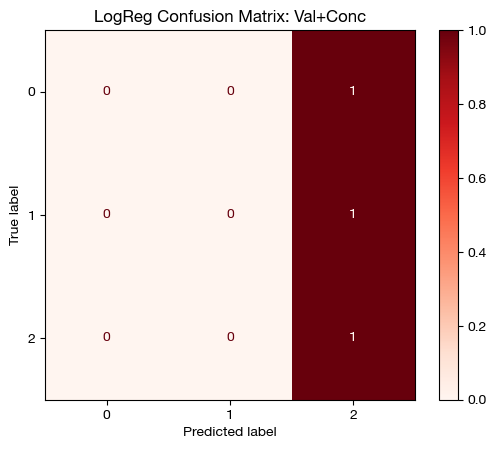

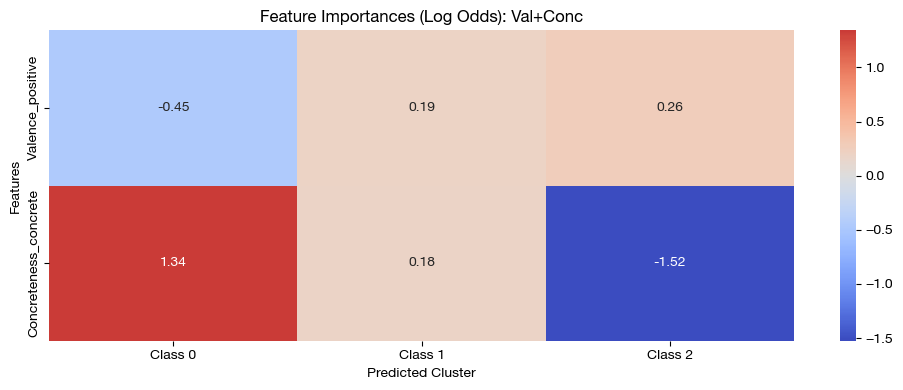

ValOnly — Logistic Regression Accuracy: 0.750


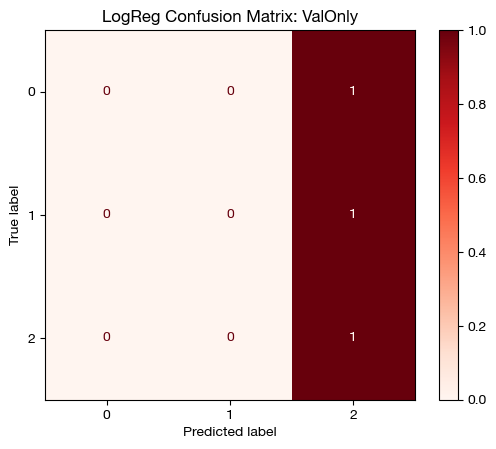

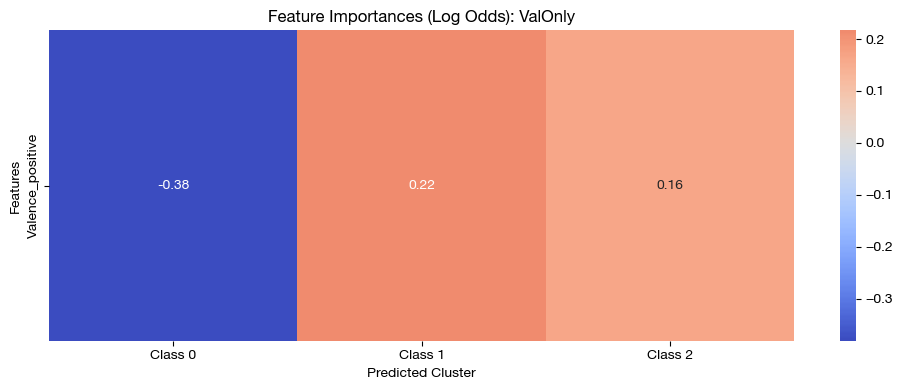

ConcOnly — Logistic Regression Accuracy: 0.750


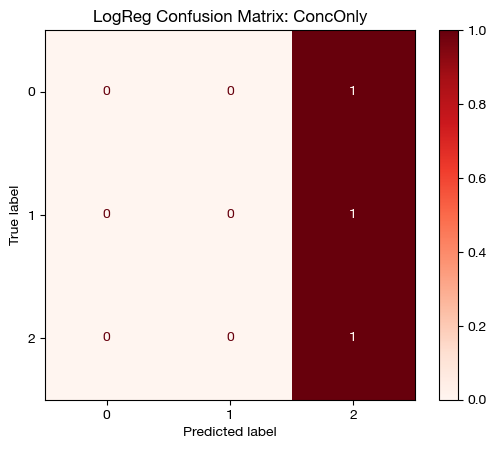

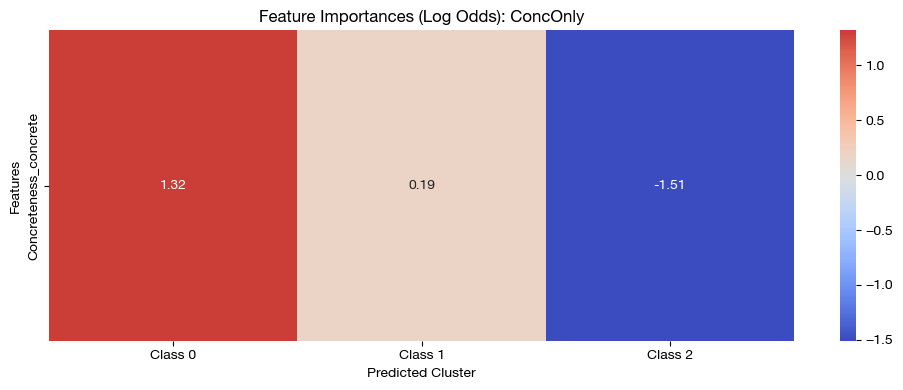

In [41]:


# Target
y = wide['GMM_Cluster']  # or 'KMeans_Cluster'

# Predictor sets
predictor_sets = {
    "All": ['Valence', 'Concreteness', 'Category'],
    "Val+Conc": ['Valence', 'Concreteness'],
    "ValOnly": ['Valence'],
    "ConcOnly": ['Concreteness']
}

# Store results
results = {}

# Loop through each model
for name, predictors in predictor_sets.items():
    X = pd.get_dummies(wide[predictors], drop_first=True)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    # Fit logistic regression
    clf = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
    clf.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} — Logistic Regression Accuracy: {acc:.3f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap='Reds')
    plt.title(f"LogReg Confusion Matrix: {name}")
    plt.show()

    # Feature Importance (Coefficients)
    coef_df = pd.DataFrame(clf.coef_, columns=X.columns)
    coef_df.index = [f"Class {label}" for label in clf.classes_]

    plt.figure(figsize=(10, 4))
    sns.heatmap(coef_df.T, annot=True, cmap='coolwarm', center=0, fmt=".2f")
    plt.title(f"Feature Importances (Log Odds): {name}")
    plt.ylabel("Features")
    plt.xlabel("Predicted Cluster")
    plt.tight_layout()
    plt.show()


In [42]:
# Create summary table from previous results
summary_df = pd.DataFrame([
    {"Model": "Logistic Regression", "Predictors": key, "Accuracy": acc}
    for key, acc in results.items()
])

# Sort by accuracy (optional)
summary_df = summary_df.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

# Display
print(summary_df)


                 Model Predictors  Accuracy
0  Logistic Regression        All  0.791667
1  Logistic Regression   Val+Conc  0.750000
2  Logistic Regression    ValOnly  0.750000
3  Logistic Regression   ConcOnly  0.750000


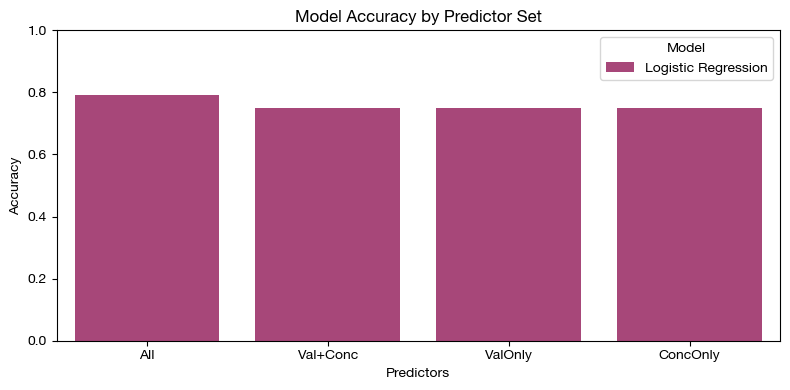

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.barplot(data=summary_df, x='Predictors', y='Accuracy', hue='Model', palette='magma')
plt.title("Model Accuracy by Predictor Set")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


# Factor Analysis

In [44]:
!pip install factor_analyzer



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [45]:
from factor_analyzer import FactorAnalyzer
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Select features (use numeric columns you want to analyze)
features = ['Mean_ReactionTime_Valence', 'Mean_Accuracy_Valence', 
            'Mean_ReactionTime_Concrete', 'Mean_Accuracy_Concrete']

# Extract data and scale it (recommended for factor analysis)
X = wide[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize FactorAnalyzer
# n_factors = number of latent factors you want to extract
fa = FactorAnalyzer(n_factors=2, rotation='varimax')  # 'varimax' rotation helps interpretability

# Fit the factor analysis model
fa.fit(X_scaled)

# Check Eigenvalues to help decide number of factors
ev, v = fa.get_eigenvalues()
print("Eigenvalues:", ev)

# Get factor loadings
loadings = pd.DataFrame(fa.loadings_, index=features, columns=[f'Factor{i+1}' for i in range(2)])
print("\nFactor Loadings:")
print(loadings)

# You can also get variance explained by each factor
print("\nVariance explained by factors:")
print(fa.get_factor_variance())


Eigenvalues: [1.5128132  1.28012257 0.75515398 0.45191025]

Factor Loadings:
                             Factor1   Factor2
Mean_ReactionTime_Valence   0.995295  0.080678
Mean_Accuracy_Valence      -0.489689  0.049793
Mean_ReactionTime_Concrete  0.020642 -0.293795
Mean_Accuracy_Concrete      0.073143  0.996163

Variance explained by factors:
(array([1.23618439, 1.08764365]), array([0.3090461 , 0.27191091]), array([0.3090461 , 0.58095701]))


In [48]:
# One-hot encode Valence and Concreteness
categorical_vars = ['Valence', 'Concreteness']
X_cat = pd.get_dummies(wide[categorical_vars], drop_first=True)

# Select numeric features
numeric_vars = ['Mean_ReactionTime_Valence', 'Mean_Accuracy_Valence', 
                'Mean_ReactionTime_Concrete', 'Mean_Accuracy_Concrete']
X_num = wide[numeric_vars]

# Combine numeric and one-hot-encoded categorical features
X_combined = pd.concat([X_num, X_cat], axis=1)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)


from factor_analyzer import FactorAnalyzer

# Fit factor analysis
fa = FactorAnalyzer(n_factors=2, rotation='varimax')
fa.fit(X_scaled)

# Eigenvalues
ev, _ = fa.get_eigenvalues()
print("Eigenvalues:", ev)

# Loadings
loadings = pd.DataFrame(fa.loadings_, index=X_combined.columns, columns=['Factor1', 'Factor2'])
print("\nFactor Loadings:")
print(loadings)

# Variance explained
print("\nVariance explained by factors:")
print(fa.get_factor_variance())



Eigenvalues: [1.53806273 1.49544315 1.01680295 0.9823022  0.54262657 0.4247624 ]

Factor Loadings:
                             Factor1   Factor2
Mean_ReactionTime_Valence  -0.495925  0.098471
Mean_Accuracy_Valence       0.989276  0.166144
Mean_ReactionTime_Concrete  0.046449 -0.263422
Mean_Accuracy_Concrete     -0.134265  0.992528
Valence_positive            0.057217  0.069985
Concreteness_concrete      -0.136956 -0.347180

Variance explained by factors:
(array([1.26682466, 1.2172346 ]), array([0.21113744, 0.20287243]), array([0.21113744, 0.41400988]))
